参考：https://qiita.com/chicken_data_analyst/items/097fe82b6a8804b59924

In [4]:
# 使わないやつもimportしてると思う
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as fm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy
from scipy.spatial import distance
import seaborn as sns
import tqdm as tq
from tqdm import tqdm
import gzip
import glob
import datetime as dt
import shutil
import collections
import functools
import gc
import sys
import time
import pickle
import zipfile
import json



そしてベイズモデリングのためのパッケージを入れるのだが、今回はGPUを使わずCPUだけ使い、複数の論理プロセッサを使いたいので、使用するプロセッサ数を指定。
指定後、数値計算ライブラリjaxで使用する論理プロセッサ数が指定した数だけあることを確認。

In [5]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))


cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [6]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)
# >> version. 5.7.2

# import numpyro
# print('version.', numpyro.__version__)
# >> version. 0.12.1


version. 5.8.0


### データ作成

In [8]:
make_data = True
if make_data:
    #### データ作成 ####
    # シード値を設定して乱数を固定化（再現性を確保）
    np.random.seed(42)
    
    # データの準備
    num_customers = 2000
    num_features_purchase = 3  # 購入回数、購入金額、最終来店日からの日数
    num_features_attributes = 4  # 性別、年齢、職業、結婚未婚
    
    # 説明変数の生成
    purchase_count = (np.random.randint(0, 20, size=num_customers))  # 購入回数
    purchase_amount = purchase_count*500 + np.random.normal(-3000, 3000, size=num_customers) + 5000  # 購入金額
    np.place(purchase_amount, purchase_amount < 0, 0)
    np.place(purchase_count, purchase_amount == 0, 0)
    days_since_last_visit = max(purchase_count*3) + purchase_count*-3 + np.random.normal(-20, 20, size=num_customers) + 30   # 最終来店日からの日数
    np.place(days_since_last_visit, days_since_last_visit < 0, 0)
    
    purchase_count = scipy.stats.zscore(purchase_count)
    purchase_amount = scipy.stats.zscore(purchase_amount)
    days_since_last_visit = scipy.stats.zscore(days_since_last_visit)
    
    X_purchase = np.concatenate([purchase_count.reshape(-1,1), purchase_amount.reshape(-1,1), days_since_last_visit.reshape(-1,1)], axis=1)
    
    # 属性情報の生成
    gender = np.random.choice(['Male', 'Female'], size=num_customers)  # 性別
    age = np.random.randint(18, 65, size=num_customers)  # 年齢
    occupation = np.random.choice(['Student', 'Professional', 'Homemaker', 'Other'], size=num_customers)  # 職業
    marital_status = np.random.choice(['Married', 'Single'], size=num_customers)  # 結婚未婚
    
    # 目的変数の生成
    # 購買データから購買有無への実際のパラメータ設定
    true_coefficients_purchase_count = np.random.uniform(0,2,size=(num_customers))
    true_coefficients_purchase_amount = np.random.uniform(0,2,size=(num_customers))
    true_coefficients_purchase_last_visit = np.random.uniform(-2,0,size=(num_customers))
    # 属性によってパラメータが大きくなる
    # 女性と学生の場合購入回数のパラメータが大きい(負の場合小さい)
    true_coefficients_purchase_count = [true_coefficients_purchase_count[i]*1.7 if gender[i] == 'Female' else true_coefficients_purchase_count[i] for i in range(num_customers)]
    true_coefficients_purchase_count = [true_coefficients_purchase_count[i]*1.6 if occupation[i] == 'Student' else true_coefficients_purchase_count[i] for i in range(num_customers)]
    # 男性とProfessionalの場合購入金額のパラメータが大きい(負の場合小さい)
    true_coefficients_purchase_amount = [true_coefficients_purchase_amount[i]*1.8 if gender[i] == 'Male' else true_coefficients_purchase_amount[i] for i in range(num_customers)]
    true_coefficients_purchase_amount = [true_coefficients_purchase_amount[i]*1.9 if occupation[i] == 'Professional' else true_coefficients_purchase_amount[i] for i in range(num_customers)]
    # 未婚と40代以上の場合最終来店日からの日数のパラメータが大きい(負の場合小さい)
    true_coefficients_purchase_last_visit = [true_coefficients_purchase_last_visit[i]*(1.5) if marital_status[i] == 'Single' else true_coefficients_purchase_last_visit[i] for i in range(num_customers)]
    true_coefficients_purchase_last_visit = [true_coefficients_purchase_last_visit[i]*(1.8) if age[i] >= 40 else true_coefficients_purchase_last_visit[i] for i in range(num_customers)]
    true_coefficients_purchase = np.vstack([true_coefficients_purchase_count, true_coefficients_purchase_amount, true_coefficients_purchase_last_visit]).T
    true_intercept_purchase = np.random.randn(1)[0]
    # 将来の購入有無
    # ノイズ
    noise_purchase = np.random.randn(num_customers)
    # 線形式
    purchase_behavior = true_intercept_purchase + np.sum(true_coefficients_purchase*X_purchase, axis=1) + noise_purchase
    # シグモイドで確率に
    purchase_probabilities = 1 / (1 + np.exp(-purchase_behavior))  # 購入確率
    purchase_events = np.round(purchase_probabilities)  # 購入有無


In [11]:
days_since_last_visit

array([ 1.26452249, -0.36100787, -1.37955813, ...,  0.30683478,
        1.67382556,  0.82185349])

In [12]:
purchase_count

array([-1.52587311,  1.65459851,  0.81763229, ...,  1.15241878,
       -1.19108662, -1.52587311])

In [14]:
X_purchase.shape

(2000, 3)

In [17]:
true_intercept_purchase

0.6588491411272431

変数まとめ
All imbalanced 0.18181818181818182
Train imbalanced 0.18144611186903137
Test imbalanced 0.18256130790190736


index  gender  age  marital_status  occupation_Homemaker  \
0        0       1   64               0                 False   
1        1       0   55               0                 False   
2        2       1   61               0                 False   
3        3       0   40               0                 False   
4        4       1   42               0                 False   
..     ...     ...  ...             ...                   ...   
728    728       1   31               0                 False   
729    729       0   54               0                 False   
730    730       1   53               1                 False   
731    731       0   64               0                 False   
732    732       1   54               0                 False   

     occupation_Other  occupation_Professional  purchase_count  \
0               False                     True       -1.525873   
1               False                     True       -1.525873   
2               False                     True       -1.525873   
3                True                    False       -1.525873   
4               False                     True       -1.023693   
..                ...                      ...             ...   
728             False                     True        0.817632   
729              True                    False        1.654599   
730             False                     True        0.650239   
731             False                    False        1.654599   
732             False                     True        0.817632   

     purchase_amount  last_visit  probabilities  purchase  
0          -1.599502    1.720704   9.357398e-10       0.0  
1          -1.520853    2.199123   4.516558e-08       0.0  
2          -1.663749    1.459561   8.954378e-07       0.0  
3          -1.663749    2.025498   1.257655e-06       0.0  
4          -1.618703    0.668734   1.360496e-06       0.0  
..               ...         ...            ...       ...  
728         1.235906   -0.984241   9.999563e-01       1.0  
729         1.282204   -1.414872   9.999592e-01       1.0  
730         1.290827   -0.936248   9.999680e-01       1.0  
731         1.596156   -1.328960   9.999838e-01       1.0  
732         1.741492   -1.192467   9.999934e-01       1.0  

[733 rows x 12 columns]

index  gender  age  marital_status  occupation_Homemaker  \
0        0       1   52               0                 False   
1        1       0   59               0                 False   
2        2       1   61               0                 False   
3        3       1   22               1                 False   
4        4       0   59               0                 False   
..     ...     ...  ...             ...                   ...   
362    362       1   60               0                 False   
363    363       1   52               0                 False   
364    364       1   18               0                 False   
365    365       0   41               0                 False   
366    366       0   62               0                 False   

     occupation_Other  occupation_Professional  purchase_count  \
0               False                     True       -1.525873   
1               False                     True       -1.525873   
2                True                    False       -1.525873   
3                True                    False       -1.525873   
4               False                     True       -1.525873   
..                ...                      ...             ...   
362             False                     True        1.487205   
363             False                    False        1.487205   
364             False                    False        0.482846   
365              True                    False        0.650239   
366             False                     True        1.319812   

     purchase_amount  last_visit  probabilities  purchase  
0          -1.663749    1.503637   1.116702e-08       0.0  
1          -1.210533    2.772080   5.137841e-07       0.0  
2          -1.663749    2.264854   1.599624e-06       0.0  
3          -1.663749    2.356594   1.041490e-05       0.0  
4          -1.663749    2.090957   1.372133e-05       0.0  
..               ...         ...            ...       ...  
362         2.141678   -1.587278   9.999635e-01       1.0  
363         0.267312   -0.777685   9.999671e-01       1.0  
364         1.873324   -1.440445   9.999693e-01       1.0  
365         0.824455   -1.587278   9.999760e-01       1.0  
366         2.157483   -1.587278   9.999996e-01       1.0  

[367 rows x 12 columns]

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

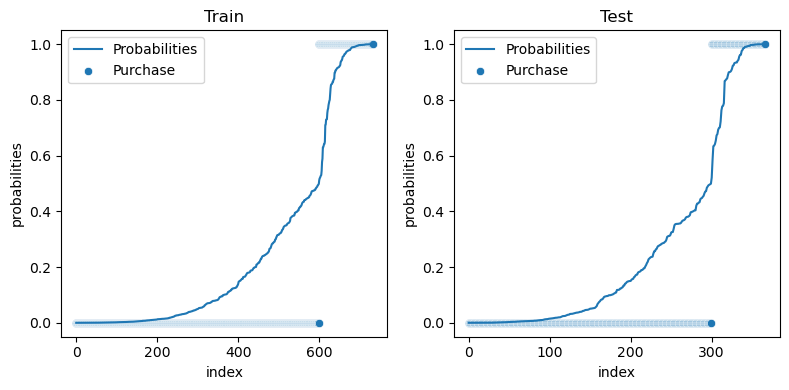

In [18]:
if make_data:
    # 変数まとめ
    print('変数まとめ')
    # 各データを一つのdfにまとめる
    concatnp = np.concatenate([gender.reshape(-1,1), age.reshape(-1,1), occupation.reshape(-1,1), marital_status.reshape(-1,1), X_purchase, purchase_probabilities.reshape(-1,1), purchase_events.reshape(-1,1)], axis=1)
    democols = ['gender','age','occupation','marital_status']  # 属性のカラム名
    purchasecols = ['purchase_count','purchase_amount','last_visit']  # 購買行動のカラム名
    objectivecols = ['probabilities','purchase']  # 目的変数のカラム名
    # df作成
    train_df = pd.DataFrame(concatnp, columns=democols+purchasecols+objectivecols)
    # 前処理
    train_df[purchasecols+objectivecols] = train_df[purchasecols+objectivecols].astype(float)  # 型変更
    train_df['age'] = train_df['age'].astype(int)  # 型変更
    train_df = pd.get_dummies(train_df, columns=['occupation'])  # OneHotEncoding
    train_df = train_df.replace({'gender': {'Male': 1, 'Female': 0}, 'marital_status': {'Married': 1, 'Single':0}}) # binary
    democols = ['gender','age','marital_status', 'occupation_Homemaker', 'occupation_Other', 'occupation_Professional'] # Encoding後の属性カラム名
    train_df = train_df[democols+purchasecols+objectivecols]
    # 2値分類はなんだかんだ不均衡がほとんどなので不均衡にしておく
    imb_idx1 = train_df[train_df['purchase']==1].sample(int(num_customers*0.1)).index.to_list()  # 正例を全体の10%に減らしIndex取得
    imb_idx0 = train_df[train_df['purchase']==0].index.to_list()  # 負例のIndex取得
    train_df = train_df.loc[(imb_idx0+imb_idx1),:].reset_index(drop=True)  # 不均衡データにする
    print('All imbalanced', train_df.purchase.sum()/len(train_df))  # 不均衡 Ratio
    # train_test_split
    train_df, test_df = train_test_split(train_df, test_size=0.3333, shuffle=True, stratify=train_df['purchase'].to_numpy())
    print('Train imbalanced', train_df.purchase.sum()/len(train_df))  # 不均衡 Ratio
    print('Test imbalanced', test_df.purchase.sum()/len(test_df))  # 不均衡 Ratio
    # probabilitiesでソート
    train_df = train_df.sort_values('probabilities').reset_index(drop=True).reset_index()
    test_df = test_df.sort_values('probabilities').reset_index(drop=True).reset_index()
    display(train_df)
    display(test_df)
    # visualization
    fig, ax = plt.subplots(1,2,figsize=(8, 4))
    sns.lineplot(data=train_df, x='index', y='probabilities', ax=ax[0], label='Probabilities')
    sns.scatterplot(data=train_df, x='index', y='purchase', ax=ax[0], label='Purchase')
    sns.lineplot(data=test_df, x='index', y='probabilities', ax=ax[1], label='Probabilities')
    sns.scatterplot(data=test_df, x='index', y='purchase', ax=ax[1], label='Purchase')
    ax[0].set_title("Train")
    ax[1].set_title("Test")
    plt.tight_layout()
    plt.show()

    # 保存
    train_df.to_csv('train_df.csv', index=False)
    test_df.to_csv('test_df.csv', index=False)


'Train'

index  gender  age  marital_status  occupation_Homemaker  occupation_Other  \
0      0       1   64               0                 False             False   
1      1       0   55               0                 False             False   
2      2       1   61               0                 False             False   
3      3       0   40               0                 False              True   
4      4       1   42               0                 False             False   

   occupation_Professional  purchase_count  purchase_amount  last_visit  \
0                     True       -1.525873        -1.599502    1.720704   
1                     True       -1.525873        -1.520853    2.199123   
2                     True       -1.525873        -1.663749    1.459561   
3                    False       -1.525873        -1.663749    2.025498   
4                     True       -1.023693        -1.618703    0.668734   

   probabilities  purchase  
0   9.357398e-10       0.0  
1   4.516558e-08       0.0  
2   8.954378e-07       0.0  
3   1.257655e-06       0.0  
4   1.360496e-06       0.0

'Test'

index  gender  age  marital_status  occupation_Homemaker  occupation_Other  \
0      0       1   52               0                 False             False   
1      1       0   59               0                 False             False   
2      2       1   61               0                 False              True   
3      3       1   22               1                 False              True   
4      4       0   59               0                 False             False   

   occupation_Professional  purchase_count  purchase_amount  last_visit  \
0                     True       -1.525873        -1.663749    1.503637   
1                     True       -1.525873        -1.210533    2.772080   
2                    False       -1.525873        -1.663749    2.264854   
3                    False       -1.525873        -1.663749    2.356594   
4                     True       -1.525873        -1.663749    2.090957   

   probabilities  purchase  
0   1.116702e-08       0.0  
1   5.137841e-07       0.0  
2   1.599624e-06       0.0  
3   1.041490e-05       0.0  
4   1.372133e-05       0.0

Train imbalanced 0.18144611186903137
Test imbalanced 0.18256130790190736


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

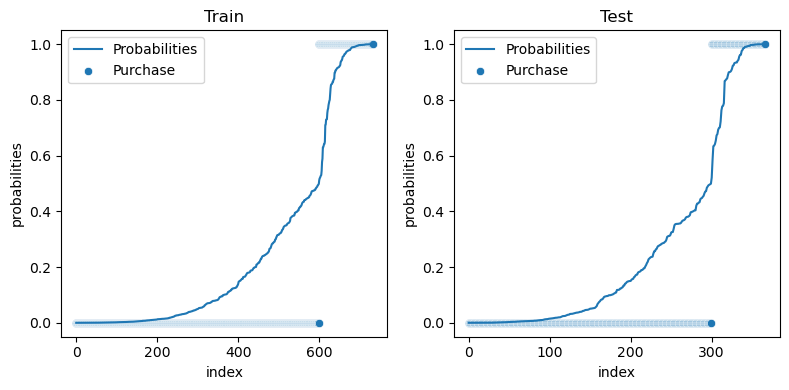

In [19]:
# 保存したものを読み込む
democols = ['gender','age','marital_status', 'occupation_Homemaker', 'occupation_Other', 'occupation_Professional']
purchasecols = ['purchase_count','purchase_amount','last_visit']
objectivecols = ['probabilities','purchase']
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
display('Train', train_df.head())
display('Test', test_df.head())
print('Train imbalanced', train_df.purchase.sum()/len(train_df))  # 不均衡 Ratio
print('Test imbalanced', test_df.purchase.sum()/len(test_df))  # 不均衡 Ratio
# visualization
fig, ax = plt.subplots(1,2,figsize=(8, 4))
sns.lineplot(data=train_df, x='index', y='probabilities', ax=ax[0], label='Probabilities')
sns.scatterplot(data=train_df, x='index', y='purchase', ax=ax[0], label='Purchase')
sns.lineplot(data=test_df, x='index', y='probabilities', ax=ax[1], label='Probabilities')
sns.scatterplot(data=test_df, x='index', y='purchase', ax=ax[1], label='Purchase')
ax[0].set_title("Train")
ax[1].set_title("Test")
plt.tight_layout()
plt.show()


In [65]:
# 混同行列
def print_cmx(y_true, y_pred):
    '''create confusion matrix
    y_true:True data
    y_pred:Pred data
    '''
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (6,6))
    sns.heatmap(df_cmx, annot=True, fmt='d', cmap='coolwarm', annot_kws={'fontsize':20},alpha=0.8)
    plt.xlabel('pred', fontsize=10)
    plt.ylabel('real', fontsize=10)
    plt.show()

# 予測確率－実測確率曲線を返す=Calibration Curve
def calib_curve(y_tests, y_pred_probas, xlim=[-0.05,1.05], ylim=[-0.05,1.05]):
    # 実測値入れる
    proba_check=pd.DataFrame(y_tests,columns=['real'])
    # 予測確率値入れる
    proba_check['pred']=y_pred_probas
    # 予測確率値10%刻み
    s_cut, bins = pd.cut(proba_check['pred'], list(np.linspace(0,1,11)), right=False, retbins=True)
    labels=bins[:-1]
    s_cut = pd.cut(proba_check['pred'], list(np.linspace(0,1,11)), right=False, labels=labels)
    proba_check['period']=s_cut.values
    # 予測確率値10%ごとの実際の確率とレコード数集計
    proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
                            , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\
                            , on=['period'], how='left')
    proba_check['period']=proba_check['period'].astype(str)
    proba_check['period']=proba_check['period'].astype(float)
    fig=plt.figure(figsize=(10,6))
    ax1 = plt.subplot(1,1,1)
    ax2=ax1.twinx()
    ax2.bar(proba_check['period'].values, proba_check['record_cnt'].values, color='gray', label="record_cnt", width=0.05, alpha=0.5)
    ax1.plot(proba_check['period'].values, proba_check['real_ratio'].values, color=sns.color_palette()[0],marker='+', label="real_ratio")
    ax1.plot(proba_check['period'].values, proba_check['period'].values, color=sns.color_palette()[2], label="ideal_line")
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(handler1 + handler2, label1 + label2, loc='center right')
    ax1.set_xlim(xlim[0],xlim[1])
    ax1.set_ylim(ylim[0],ylim[1])
    ax1.set_xlabel('period')
    ax1.set_ylabel('real_ratio %')
    ax2.set_ylabel('record_cnt')
    ax2.grid(False)
    plt.show()
    display(proba_check)

# 実際の確率と予測確率の比較
def probabilities_compare(p_true, p_pred, y_true, y_pred):
    idx = np.argsort(p_true)
    plt.plot(range(len(p_pred)), p_pred[idx], label='Pred probabilities', marker='x', alpha=0.6)
    plt.scatter(range(len(p_pred)), np.random.normal(y_pred[idx], 0.02), marker='o', label='Pred', alpha=0.6)
    plt.plot(range(len(p_pred)), p_true[idx], label='True probabilities', marker='+', alpha=0.6)
    plt.scatter(range(len(p_pred)), np.random.normal(y_true[idx], 0.02), marker='>', label='True', alpha=0.6)
    plt.legend()
    plt.show()

# 分類指標、混同行列、予測確率-実測確率プロット(キャリブレーションカーブ)を出力
def result_summary(p_true, p_pred, y_true, y_pred):
    print('accuracy_score', sklearn.metrics.accuracy_score(y_true, y_pred))
    print('precision_score', sklearn.metrics.precision_score(y_true, y_pred))
    print('recall_score', sklearn.metrics.recall_score(y_true, y_pred))
    print('f1_score', sklearn.metrics.f1_score(y_true, y_pred))
    print_cmx(y_true, y_pred)
    calib_curve(y_true, p_pred, xlim=[-0.05,1.05], ylim=[-0.05,1.05])
    probabilities_compare(p_true, p_pred, y_true, y_pred)

# バイオリンプロット
def plot_violin(data, order=None, xlabel=None, ylabel=None, title=None, figsize=(10,4)):
    fig=plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,1,1)
    sns.violinplot(data=data, ax=ax1, order=order, scale='width')
    plt.setp(ax1.get_xticklabels(), rotation=20)
    for i, col in enumerate(corf_df.columns):
        ax1.text(i, corf_df[col].mean(), round(corf_df[col].mean(),2), fontsize=10, ha="left", color="k")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title)
    # plt.rcParams['font.family'] = prop.get_name()
    #plt.tight_layout()
    plt.show()

# 各個人のランダム係数効果計算
def random_coef_effect(trace, name):
    indivisual_coef_purchase_samples = trace.posterior[name].mean(dim=["chain"]).values
    indivisual_coef_purchase_samples_count = pd.DataFrame(indivisual_coef_purchase_samples[:, :, 0])
    indivisual_coef_purchase_samples_amount = pd.DataFrame(indivisual_coef_purchase_samples[:, :, 1])
    indivisual_coef_purchase_samples_last_visit = pd.DataFrame(indivisual_coef_purchase_samples[:, :, 2])
    return indivisual_coef_purchase_samples_count, indivisual_coef_purchase_samples_amount, indivisual_coef_purchase_samples_last_visit
    
# 個人単位のランダム係数のboxplot
def indivisual_plot(indivisual_coef, ylabel=None, title=None, brk=True):
    for i in (range(100, indivisual_coef.shape[1]+100, 100)):
        fig=plt.figure(figsize=(30,6))
        ax1 = plt.subplot(1,1,1)
        sns.boxplot(data=indivisual_coef.iloc[:,i-100:i], ax=ax1)
        plt.setp(ax1.get_xticklabels(), rotation=90)
        ax1.set_ylabel(ylabel)
        ax1.set_title(title)
        # plt.rcParams['font.family'] = prop.get_name()
        #plt.tight_layout()
        plt.show()
        if brk:
            break

# 3種の属性グループのランダム係数のviolin plot
def indivisual_summary_plot(train_df, democols, indivisual_count, indivisual_amount, indivisual_last_visit):
    DfForPlot = train_df[democols].copy()
    DfForPlot['coef_count'] = indivisual_count.mean(axis=0)
    DfForPlot['coef_amount'] = indivisual_amount.mean(axis=0)
    DfForPlot['coef_last_visit'] = indivisual_last_visit.mean(axis=0)
    case1 = DfForPlot[(DfForPlot['gender']==0)&(DfForPlot['occupation_Homemaker']==0)&(DfForPlot['occupation_Other']==0)&(DfForPlot['occupation_Professional']==0)]
    case2 = DfForPlot[(DfForPlot['gender']==1)&(DfForPlot['occupation_Homemaker']==0)&(DfForPlot['occupation_Other']==0)&(DfForPlot['occupation_Professional']==1)]
    case3 = DfForPlot[(DfForPlot['age']>=40)&(DfForPlot['marital_status']==0)]
    length = max(len(case1),len(case2),len(case3))

    caseAll = pd.DataFrame()
    caseAll['coef_count1'] = np.pad(case1['coef_count'].to_numpy(),(0,length-len(case1['coef_count'].to_numpy())), mode='constant', constant_values=np.nan)
    caseAll['coef_count2'] = np.pad(case2['coef_count'].to_numpy(),(0,length-len(case2['coef_count'].to_numpy())), mode='constant', constant_values=np.nan)
    caseAll['coef_count3'] = np.pad(case3['coef_count'].to_numpy(),(0,length-len(case3['coef_count'].to_numpy())), mode='constant', constant_values=np.nan)
    fig=plt.figure(figsize=(6,10))
    ax1 = plt.subplot(3,1,1)
    sns.violinplot(data=caseAll, ax=ax1, order=['coef_count1','coef_count2','coef_count3'])
    plt.setp(ax1.get_xticklabels(), rotation=20)
    ax1.set_ylabel('購入回数の係数')
    ax1.set_title('"購入回数"の係数が各個人の属性情報によってばらつくことをモデル化')
    
    caseAll = pd.DataFrame()
    caseAll['coef_amount1'] = np.pad(case1['coef_amount'].to_numpy(),(0,length-len(case1['coef_amount'].to_numpy())), mode='constant', constant_values=np.nan)
    caseAll['coef_amount2'] = np.pad(case2['coef_amount'].to_numpy(),(0,length-len(case2['coef_amount'].to_numpy())), mode='constant', constant_values=np.nan)
    caseAll['coef_amount3'] = np.pad(case3['coef_amount'].to_numpy(),(0,length-len(case3['coef_amount'].to_numpy())), mode='constant', constant_values=np.nan)
    ax1 = plt.subplot(3,1,2)
    sns.violinplot(data=caseAll, ax=ax1, order=['coef_amount1','coef_amount2','coef_amount3'])
    plt.setp(ax1.get_xticklabels(), rotation=20)
    ax1.set_ylabel('購入金額の係数')
    ax1.set_title('"購入金額"の係数が各個人の属性情報によってばらつくことをモデル化')
    
    caseAll = pd.DataFrame()
    caseAll['coef_last_visit1'] = np.pad(case1['coef_last_visit'].to_numpy(),(0,length-len(case1['coef_last_visit'].to_numpy())), mode='constant', constant_values=np.nan)
    caseAll['coef_last_visit2'] = np.pad(case2['coef_last_visit'].to_numpy(),(0,length-len(case2['coef_last_visit'].to_numpy())), mode='constant', constant_values=np.nan)
    caseAll['coef_last_visit3'] = np.pad(case3['coef_last_visit'].to_numpy(),(0,length-len(case3['coef_last_visit'].to_numpy())), mode='constant', constant_values=np.nan)
    ax1 = plt.subplot(3,1,3)
    sns.violinplot(data=caseAll, ax=ax1, order=['coef_last_visit1','coef_last_visit2','coef_last_visit3'])
    plt.setp(ax1.get_xticklabels(), rotation=20)
    ax1.set_ylabel('最終来店からの日数の係数')
    ax1.set_title('"最終来店からの日数"の係数が各個人の属性情報によってばらつくことをモデル化')
    # plt.rcParams['font.family'] = prop.get_name()
    plt.tight_layout()
    plt.show()


### ロジスティック回帰、おそらく最尤推定

coef_ {'gender': -0.26, 'age': 0.01, 'marital_status': 0.11, 'occupation_Homemaker': 0.17, 'occupation_Other': -0.58, 'occupation_Professional': -0.17, 'purchase_count': 1.43, 'purchase_amount': 1.82, 'last_visit': -1.72}
accuracy_score 0.9386084583901774
precision_score 0.8859649122807017
recall_score 0.7593984962406015
f1_score 0.8178137651821863


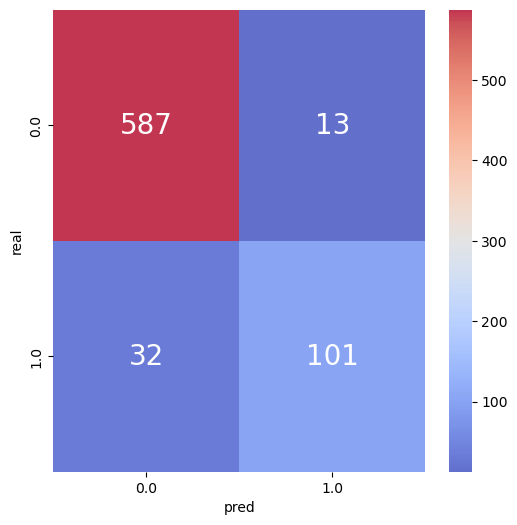

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2175797120.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2175797120.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


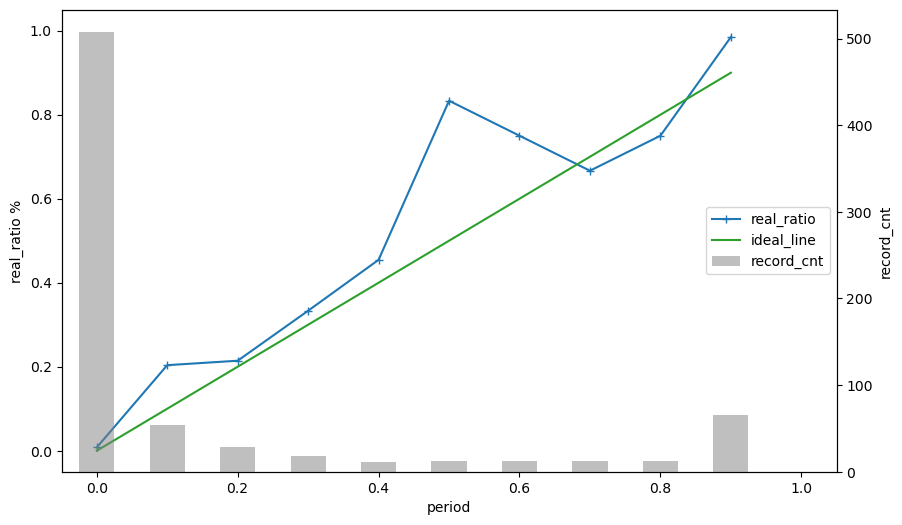

period  real_ratio  record_cnt
0     0.0    0.007874         508
1     0.1    0.203704          54
2     0.2    0.214286          28
3     0.3    0.333333          18
4     0.4    0.454545          11
5     0.5    0.833333          12
6     0.6    0.750000          12
7     0.7    0.666667          12
8     0.8    0.750000          12
9     0.9    0.984848          66

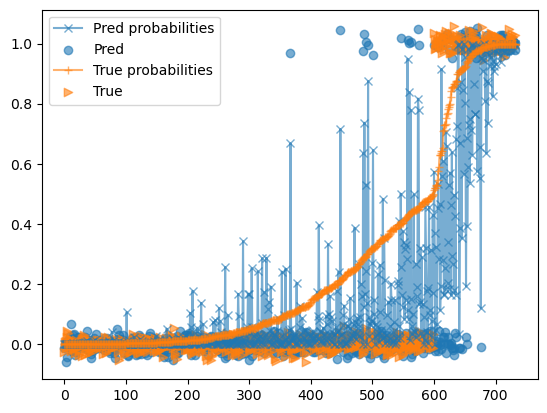

accuracy_score 0.9209809264305178
precision_score 0.8392857142857143
recall_score 0.7014925373134329
f1_score 0.7642276422764228


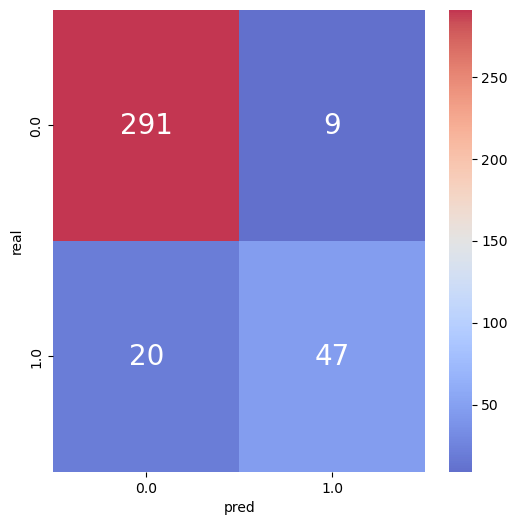

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2175797120.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2175797120.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


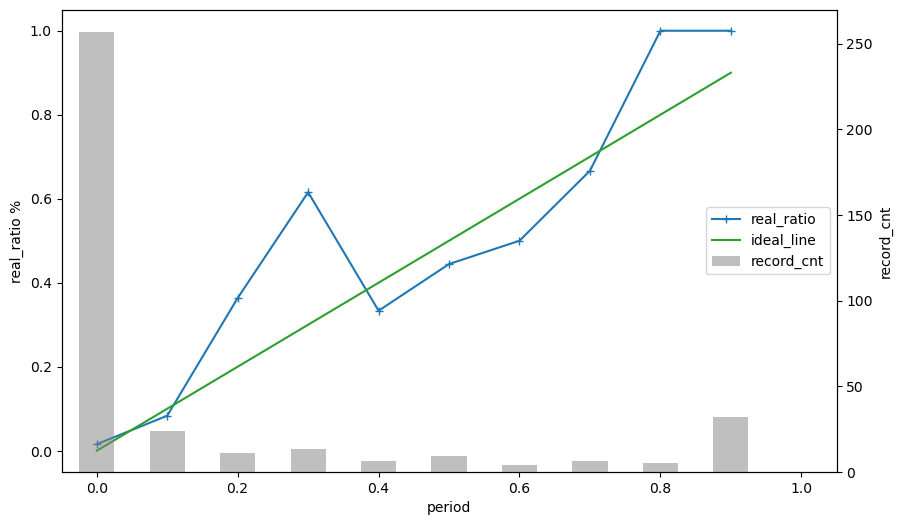

period  real_ratio  record_cnt
0     0.0    0.015564         257
1     0.1    0.083333          24
2     0.2    0.363636          11
3     0.3    0.615385          13
4     0.4    0.333333           6
5     0.5    0.444444           9
6     0.6    0.500000           4
7     0.7    0.666667           6
8     0.8    1.000000           5
9     0.9    1.000000          32

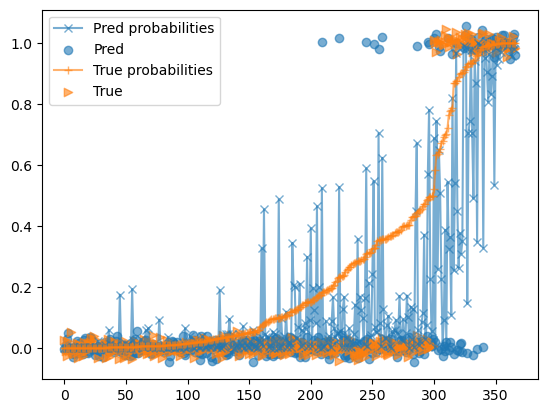

In [21]:
# 学習データ、テストデータ定義
# 説明変数は購買行動と属性情報
X_train = train_df[democols+purchasecols]
y_train = train_df['purchase']
X_test = test_df[democols+purchasecols]

# モデルの初期化
modellr = LogisticRegression()

# モデルのトレーニング
modellr.fit(X_train, y_train)

coef_dict = {i:round(j,2) for i,j in zip(democols+purchasecols, modellr.coef_[0])}
print('coef_', coef_dict)
# 学習データを使って予測
p_pred = modellr.predict_proba(X_train)[:,1]
y_pred = (p_pred >= 0.5).astype("int")  # 0.5以上を1
y_true = train_df['purchase'].to_numpy()  # 実際の購買有無
p_true = train_df['probabilities'].to_numpy()
result_summary(p_true, p_pred, y_true, y_pred)

# テストデータを使って予測
p_pred_test = modellr.predict_proba(X_test)[:,1]
y_pred_test = (p_pred_test >= 0.5).astype("int")  # 0.5以上を1
y_true_test = test_df['purchase'].to_numpy()  # 実際の購買有無
p_true_test = test_df['probabilities'].to_numpy()
result_summary(p_true_test, p_pred_test, y_true_test, y_pred_test)


### ベイズロジスティック回帰モデル

In [22]:
train_df.shape

(733, 12)

In [23]:
democols

['gender',
 'age',
 'marital_status',
 'occupation_Homemaker',
 'occupation_Other',
 'occupation_Professional']

In [24]:
purchasecols

['purchase_count', 'purchase_amount', 'last_visit']

In [25]:
train_df['purchase']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
728    1.0
729    1.0
730    1.0
731    1.0
732    1.0
Name: purchase, Length: 733, dtype: float64

In [35]:
# モデルの定義
with pm.Model() as model_logi:
    # coords(次元やインデックスを定義)
    model_logi.add_coord('data', values=range(train_df.shape[0]), mutable=True)
    model_logi.add_coord('var', values=democols+purchasecols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', train_df[democols+purchasecols].to_numpy(dtype='float32'), dims=('data', 'var'))
    y = pm.MutableData("y", train_df['purchase'].to_numpy(dtype='float32'), dims=('data', ))

    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0.0, sigma=1, dims="var")  # 各係数の事前分布は正規分布
    intercept_ = pm.Normal('intercept', mu=0.0, sigma=1.0)  # 切片の事前分布は正規分布
    # linear model
    mu = pm.Deterministic("mu", coef_.dot(x.T) + intercept_, dims=('data', ))
    # link function
    link = pm.Deterministic("link", pm.math.invlogit(mu), dims=('data', ))
    # likelihood
    result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_logi.model)


     coef ~ Normal(0, 1)
intercept ~ Normal(0, 1)
       mu ~ Deterministic(f(intercept, coef))
     link ~ Deterministic(f(intercept, coef))
      obs ~ Bernoulli(link)

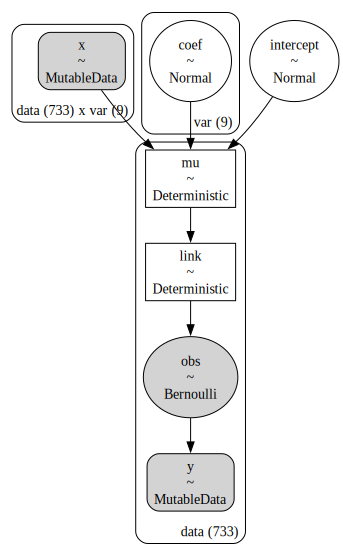

In [37]:
# モデル構造
modeldag = pm.model_to_graphviz(model_logi)
display(modeldag)


MCMC

In [38]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_logi:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True)
# >> Wall time: 7.58 s


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:04.605184
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 0:  75%|███████▌  | 3000/4000 [00:02<00:00, 3937.09it/s]

Running chain 0:  90%|█████████ | 3600/4000 [00:02<00:00, 4169.82it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:02<00:00, 1512.33it/s]


Sampling time =  0:00:02.854606
Transforming variables...
Transformation time =  0:00:00.064185
CPU times: user 6.28 s, sys: 551 ms, total: 6.83 s
Wall time: 20.9 s


In [39]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ["coef", "intercept"]])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')
# >>Max rhat: 1.0010951683443083


Max rhat: 1.0008009604596724


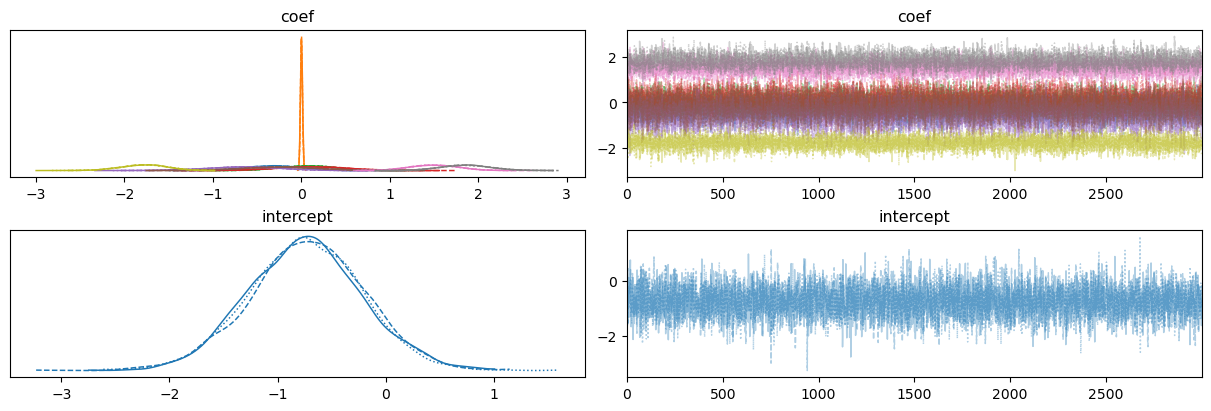

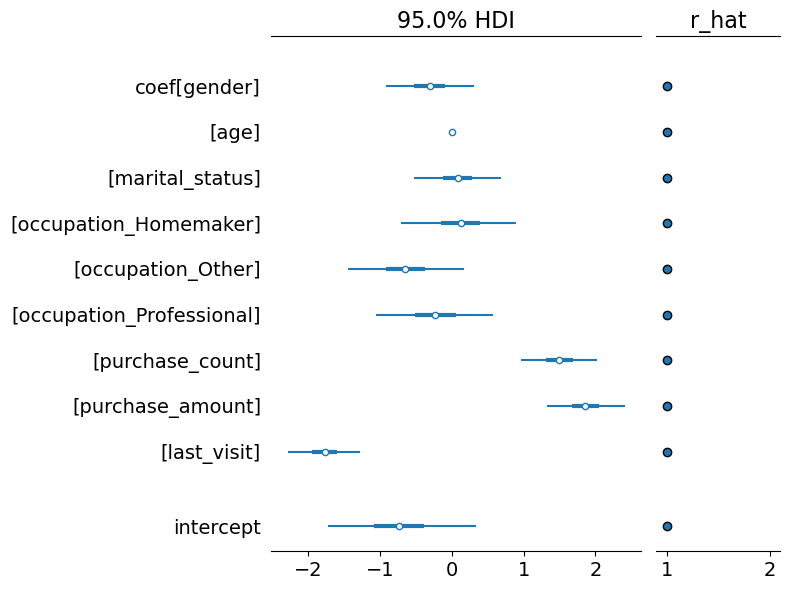

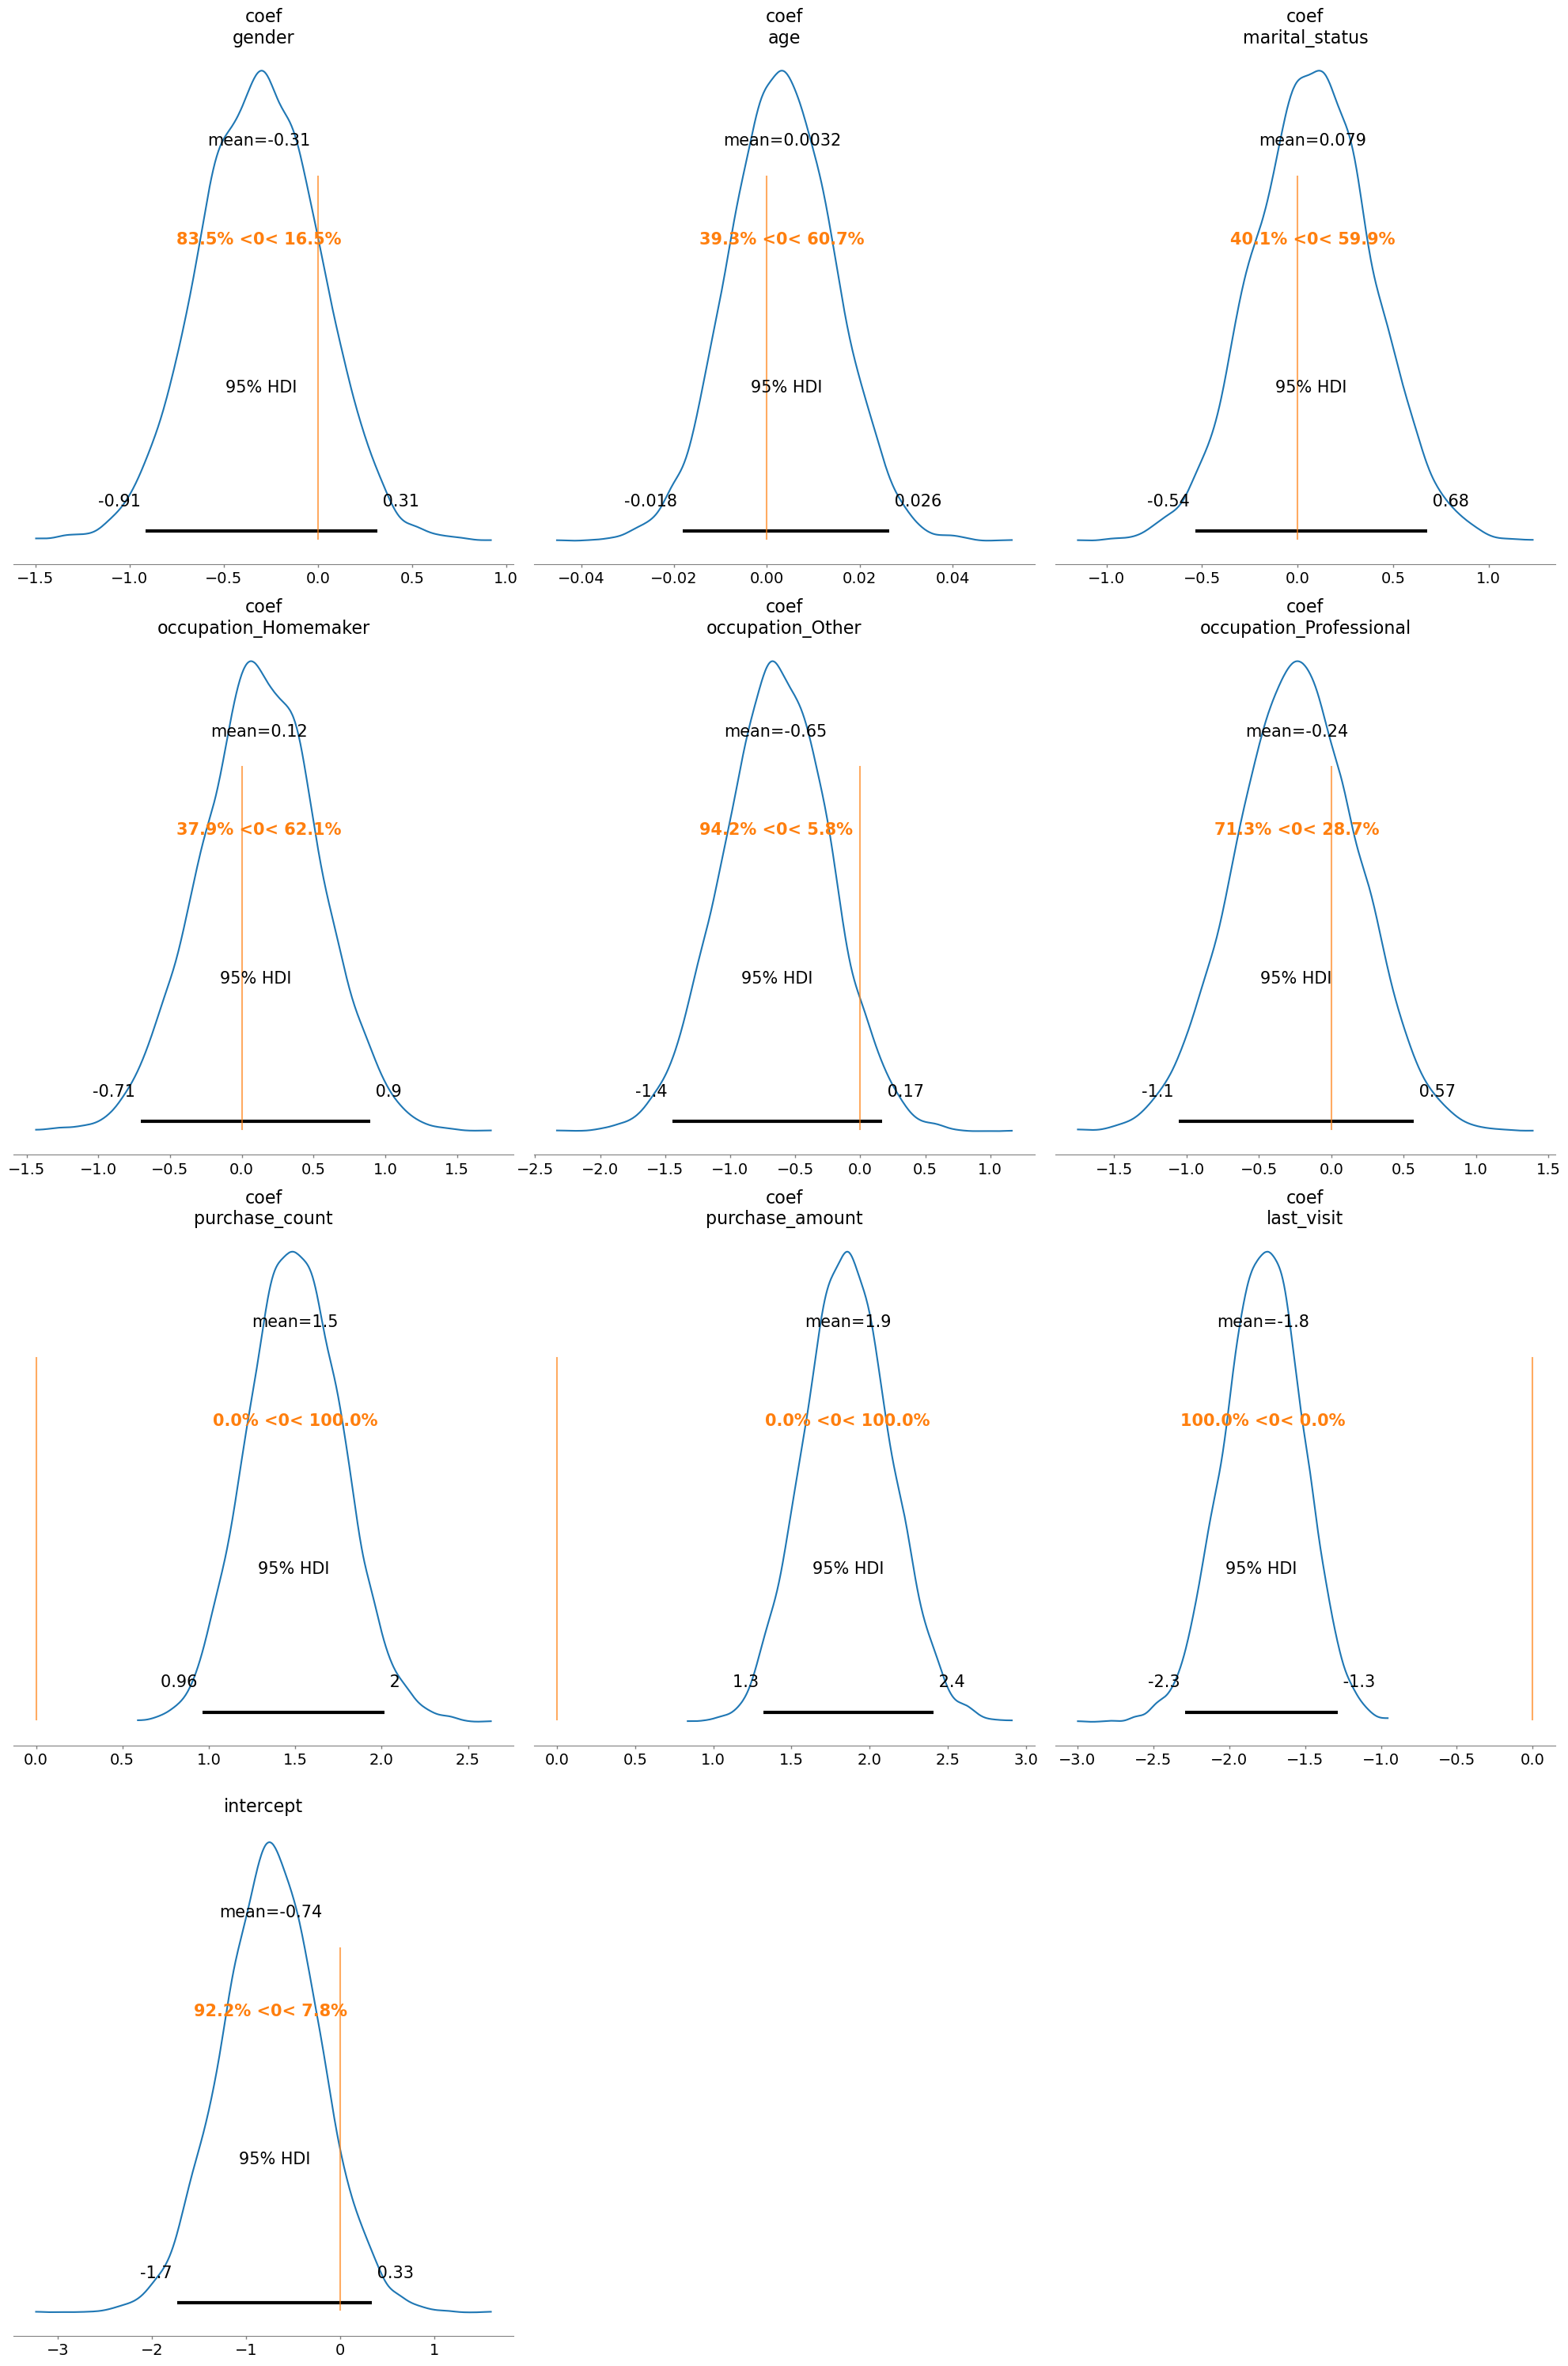

In [40]:
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef", "intercept"])
plt.show()

# forest plotでRハットと一緒に可視化
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept"])
plt.tight_layout()
plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=["coef", "intercept"], ref_val=0, figsize=(20,30))
plt.tight_layout()
plt.show()


予測サンプル生成（学習データ）

In [43]:
# 事後分布から予測サンプルを生成
with model_logi:
    idata = pm.sample_posterior_predictive(trace)


Sampling: [obs]


accuracy_score 0.9386084583901774
precision_score 0.8793103448275862
recall_score 0.7669172932330827
f1_score 0.8192771084337349


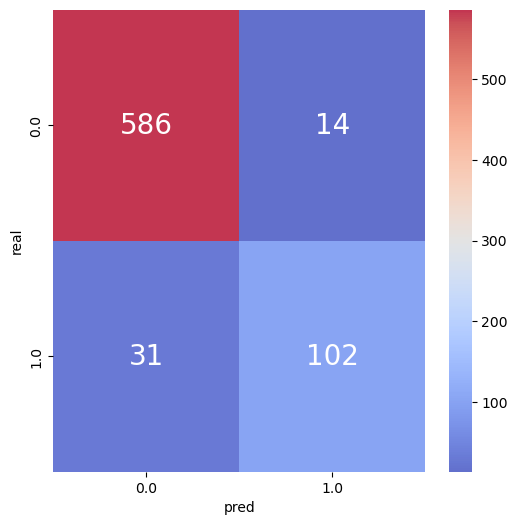

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2175797120.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2175797120.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


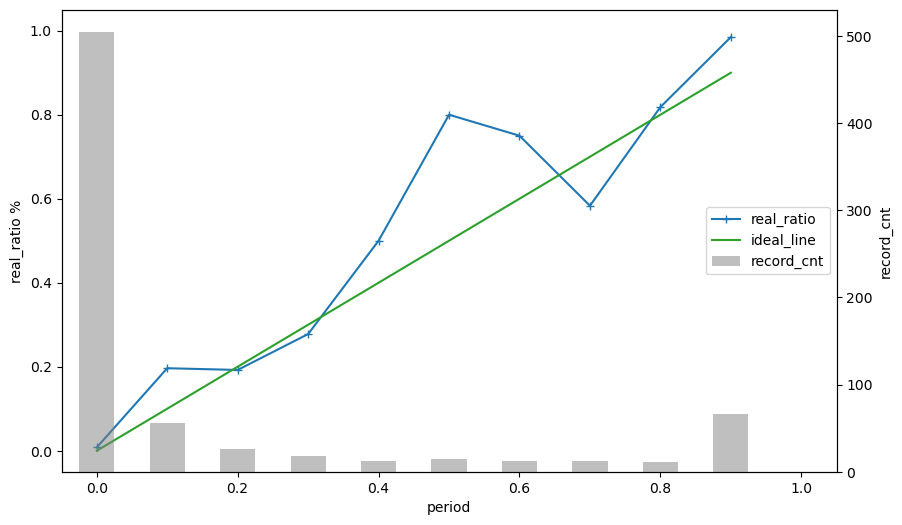

period  real_ratio  record_cnt
0     0.0    0.007921         505
1     0.1    0.196429          56
2     0.2    0.192308          26
3     0.3    0.277778          18
4     0.4    0.500000          12
5     0.5    0.800000          15
6     0.6    0.750000          12
7     0.7    0.583333          12
8     0.8    0.818182          11
9     0.9    0.984848          66

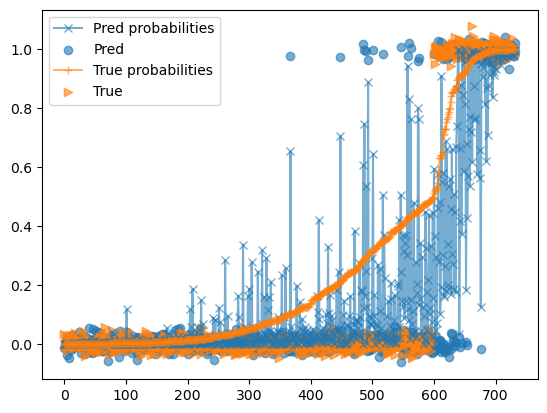

In [44]:
# 学習データを使って予測
p_preds = idata.posterior_predictive['obs'].mean(dim=["chain"]).values  # chain平均
p_pred = idata.posterior_predictive['obs'].mean(dim=["chain", "draw"]).values  # chainとサンプル平均
y_pred = (p_pred >= 0.5).astype("int")  # 0.5以上を1
y_true = train_df['purchase'].to_numpy()  # 実際の購買有無
p_true = train_df['probabilities'].to_numpy()
result_summary(p_true, p_pred, y_true, y_pred)


{'gender': -0.31, 'age': 0.0, 'marital_status': 0.08, 'occupation_Homemaker': 0.12, 'occupation_Other': -0.65, 'occupation_Professional': -0.24, 'purchase_count': 1.5, 'purchase_amount': 1.86, 'last_visit': -1.78}


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

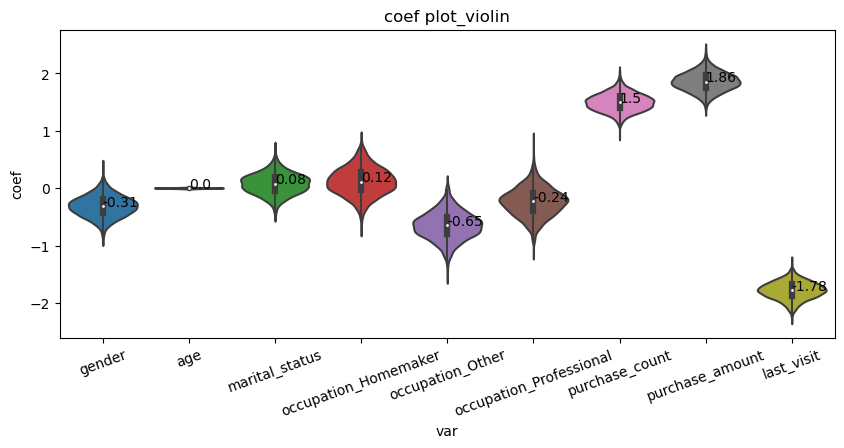

In [47]:
corf_df = pd.DataFrame(trace.posterior['coef'].mean(dim=["chain"]).values, columns=democols+purchasecols)
coef_dict = {i:round(corf_df[i].mean(),2) for i in democols+purchasecols}
print(coef_dict)
plot_violin(corf_df, order=None, xlabel='var', ylabel='coef', title='coef plot_violin')


予測サンプル生成（テストデータ）

In [49]:
# テストデータの推論
with model_logi:
    pm.set_data({'x':test_df[democols+purchasecols].to_numpy(dtype='float32')
                , 'y': np.zeros(len(test_df[democols+purchasecols].to_numpy(dtype='float32')))  # yは未知とする。実際の答えはtest_df['purchase'].to_numpy()。
                }
                , coords={"data": (np.arange(test_df.shape[0]))+train_df.shape[0]}
                )
    trace.extend(pm.sample_posterior_predictive(trace))


Sampling: [obs]


accuracy_score 0.9182561307901907
precision_score 0.8245614035087719
recall_score 0.7014925373134329
f1_score 0.7580645161290324


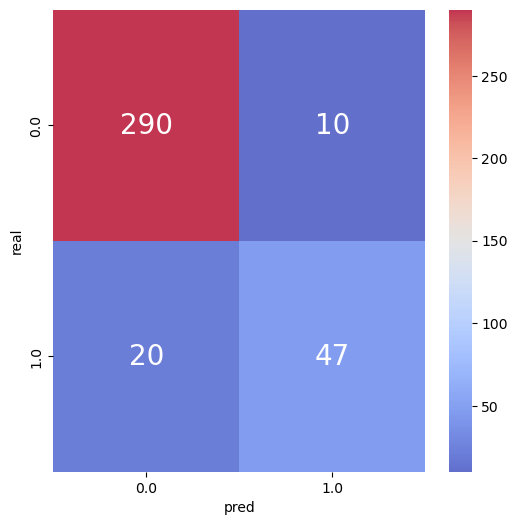

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2197257563.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2197257563.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


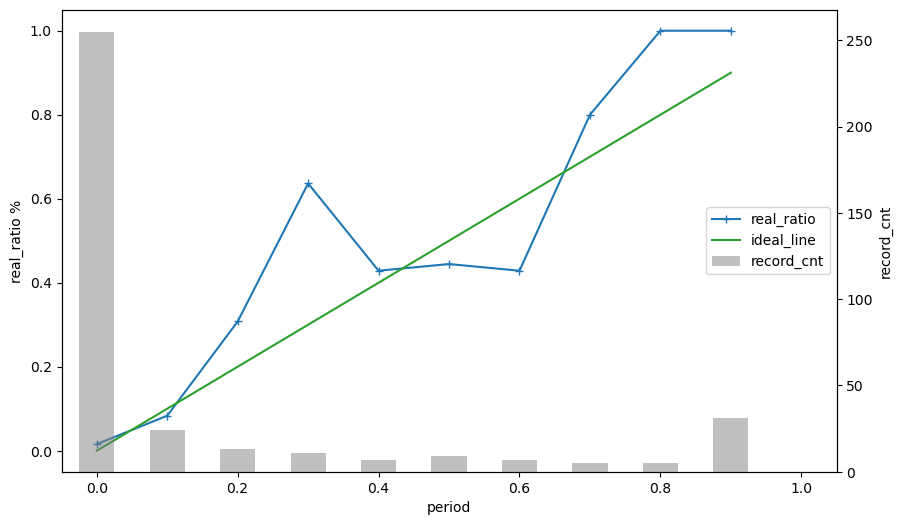

period  real_ratio  record_cnt
0     0.0    0.015686         255
1     0.1    0.083333          24
2     0.2    0.307692          13
3     0.3    0.636364          11
4     0.4    0.428571           7
5     0.5    0.444444           9
6     0.6    0.428571           7
7     0.7    0.800000           5
8     0.8    1.000000           5
9     0.9    1.000000          31

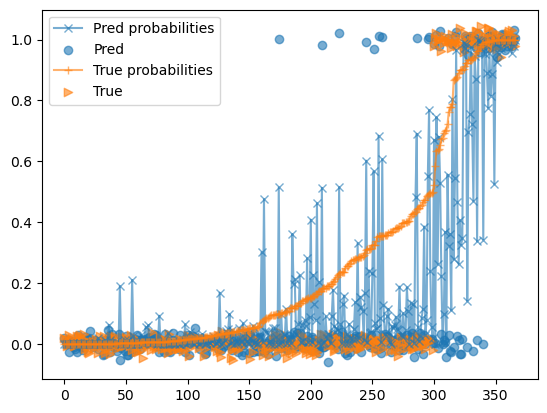

In [50]:
# テストデータを使って予測
p_preds_test = trace.posterior_predictive["obs"].mean(dim=["chain"]).values  # chain平均
p_pred_test = trace.posterior_predictive["obs"].mean(dim=["chain", "draw"]).values  # chainとサンプル平均
y_pred_test = (p_pred_test >= 0.5).astype("int")  # 0.5以上を1
y_true_test = test_df['purchase'].to_numpy()  # 実際の購買有無
p_true_test = test_df['probabilities'].to_numpy()
result_summary(p_true_test, p_pred_test, y_true_test, y_pred_test)


### 階層ベイズ２項ロジットモデル、属性情報なし、固定効果あり、ランダム効果あり

In [51]:
# モデルの定義
with pm.Model() as model_random1:
    # coords
    model_random1.add_coord('data', values=range(train_df.shape[0]), mutable=True)
    model_random1.add_coord('var', values=purchasecols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', train_df[purchasecols].to_numpy(dtype='float32'), dims=('data', 'var'))
    y = pm.MutableData("y", train_df['purchase'].to_numpy(dtype='float32'), dims=('data', ))

    # 推論パラメータの超事前分布
    super_mu_keisuu = pm.Normal('super_mu_keisuu', mu=0, sigma=1, dims=('var'))  # ランダム係数の平均の超事前分布
    super_mu_seppen = pm.Normal('super_mu_seppen', mu=0, sigma=1)  # ランダム切片の平均の超事前分布
    #super_sigma_keisuu = pm.HalfStudentT('super_sigma_keisuu', nu=4, dims=('var'))  # MCMC収束しなかったので設定しない
    #super_sigma_seppen = pm.HalfStudentT('super_sigma_seppen', nu=4)  #  MCMC収束しなかったので設定しない
    
    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0, sigma=1, dims=('var'))  # 係数の事前分布
    intercept_ = pm.Normal('intercept', mu=0, sigma=1)  # 切片の事前分布 
    r_coef_ = pm.Normal('r_coef_', mu=super_mu_keisuu, sigma=1, dims=('data', 'var'))  # ランダム係数の事前分布  データ×係数の数分の値がある
    r_intercept_ = pm.Normal('r_intercept_', mu=super_mu_seppen, sigma=1, dims=('data', ))  # ランダム切片の事前分布   データ分の値がある
    
    # linear model
    mu = pm.Deterministic("mu", pm.math.sum((coef_+r_coef_)*x, axis=1) + intercept_ + r_intercept_, dims=('data', ))
    # link function
    link = pm.Deterministic("link", pm.math.invlogit(mu), dims=('data', ))  # リンク関数
    # likelihood
    result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))  # 尤度関数


In [52]:
purchasecols

['purchase_count', 'purchase_amount', 'last_visit']

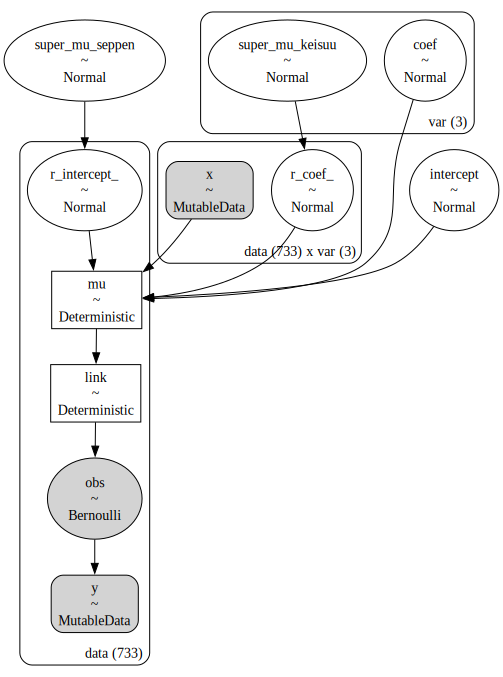

In [53]:
# 構造
modeldag = pm.model_to_graphviz(model_random1)
display(modeldag)


In [54]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_random1:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')


Compiling...
Compilation time =  0:00:03.069159
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

Running chain 0:   0%|          | 0/4000 [00:01<?, ?it/s]

Running chain 2: 100%|██████████| 4000/4000 [00:30<00:00, 129.58it/s]


Sampling time =  0:00:31.079040
Transforming variables...
Transformation time =  0:00:00.265304
CPU times: user 1min 16s, sys: 7.26 s, total: 1min 23s
Wall time: 50.6 s


'model_random1.nc'

In [55]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ["coef", "intercept", "r_coef_", "r_intercept_"]])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')

'''
# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef", "intercept", "r_coef_", "r_intercept_"])
plt.show()

# forest plotでRハットと一緒に可視化
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["r_coef_", "r_intercept_"])
plt.tight_layout()
plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=["coef_purchase"], ref_val=0, figsize=(20,30))
plt.tight_layout()
plt.show()

# Energy Plot
az.plot_energy(trace)
plt.show()
'''


Max rhat: 1.163918519578896
super_mu_keisuu  ====>  1.2113453410891482  ====>  1.146786432974343  ====>  (3,)
super_mu_seppen  ====>  1.110643542235324  ====>  1.110643542235324  ====>  ()
coef  ====>  1.163918519578896  ====>  1.113464997921199  ====>  (3,)
intercept  ====>  1.1012959362194532  ====>  1.1012959362194532  ====>  ()


'\n# トレースプロットとか\n# plot_trace\naz.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef", "intercept", "r_coef_", "r_intercept_"])\nplt.show()\n\n# forest plotでRハットと一緒に可視化\naz.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["r_coef_", "r_intercept_"])\nplt.tight_layout()\nplt.show()\n\n# 事後分布の確認\naz.plot_posterior(trace, hdi_prob=0.95, var_names=["coef_purchase"], ref_val=0, figsize=(20,30))\nplt.tight_layout()\nplt.show()\n\n# Energy Plot\naz.plot_energy(trace)\nplt.show()\n'

予測サンプル生成（学種データ）

Sampling: [obs]


accuracy_score 0.9590723055934516
precision_score 0.9401709401709402
recall_score 0.8270676691729323
f1_score 0.8799999999999999


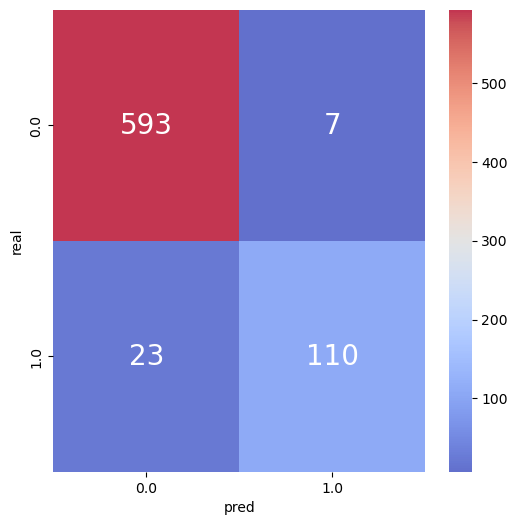

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2197257563.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/2197257563.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


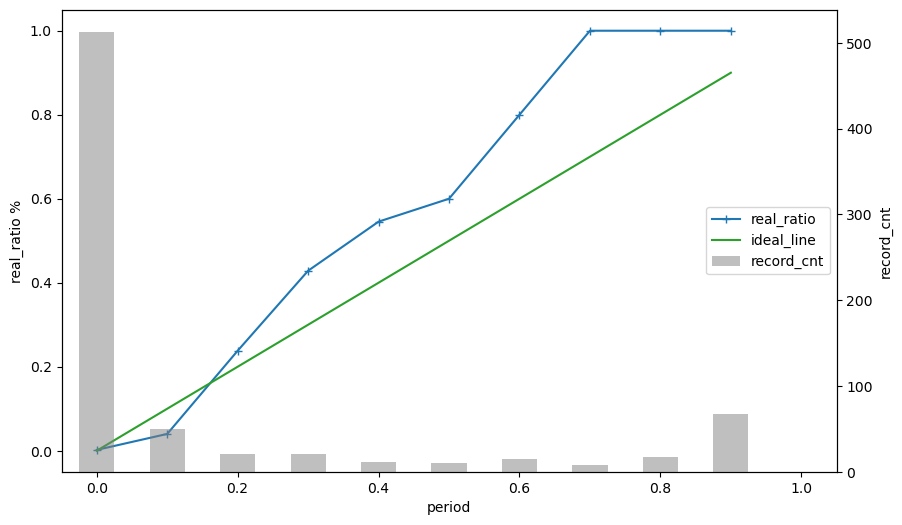

period  real_ratio  record_cnt
0     0.0    0.001949         513
1     0.1    0.040000          50
2     0.2    0.238095          21
3     0.3    0.428571          21
4     0.4    0.545455          11
5     0.5    0.600000          10
6     0.6    0.800000          15
7     0.7    1.000000           8
8     0.8    1.000000          17
9     0.9    1.000000          67

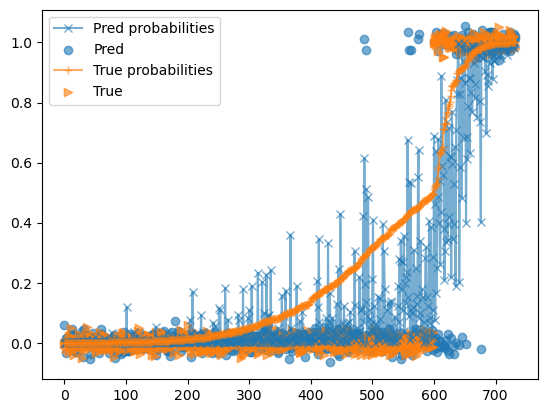

In [57]:
# 事後分布
with model_random1:
    idata = pm.sample_posterior_predictive(trace)

# 学習データを使って予測
p_preds = idata.posterior_predictive['obs'].mean(dim=["chain"]).values  # chain平均
p_pred = idata.posterior_predictive['obs'].mean(dim=["chain", "draw"]).values  # chainとサンプル平均
y_pred = (p_pred >= 0.5).astype("int")  # 0.5以上を1
y_true = train_df['purchase'].to_numpy()  # 実際の購買有無
p_true = train_df['probabilities'].to_numpy()
result_summary(p_true, p_pred, y_true, y_pred)


推定パラメータ確認

{'purchase_count': 1.0, 'purchase_amount': 1.15, 'last_visit': -1.22}


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


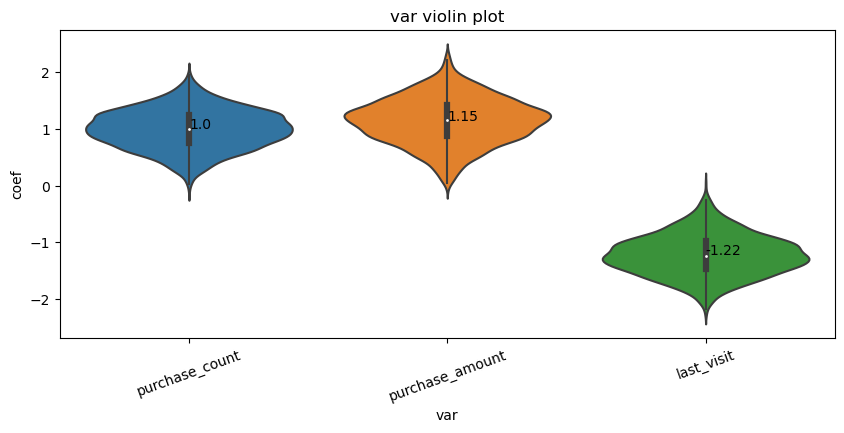

In [59]:
corf_df = pd.DataFrame(trace.posterior['coef'].mean(dim=["chain"]).values, columns=purchasecols)
coef_dict = {i:round(corf_df[i].mean(),2) for i in purchasecols}
print(coef_dict)
plot_violin(corf_df, order=None, xlabel='var', ylabel='coef', title='var violin plot')


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

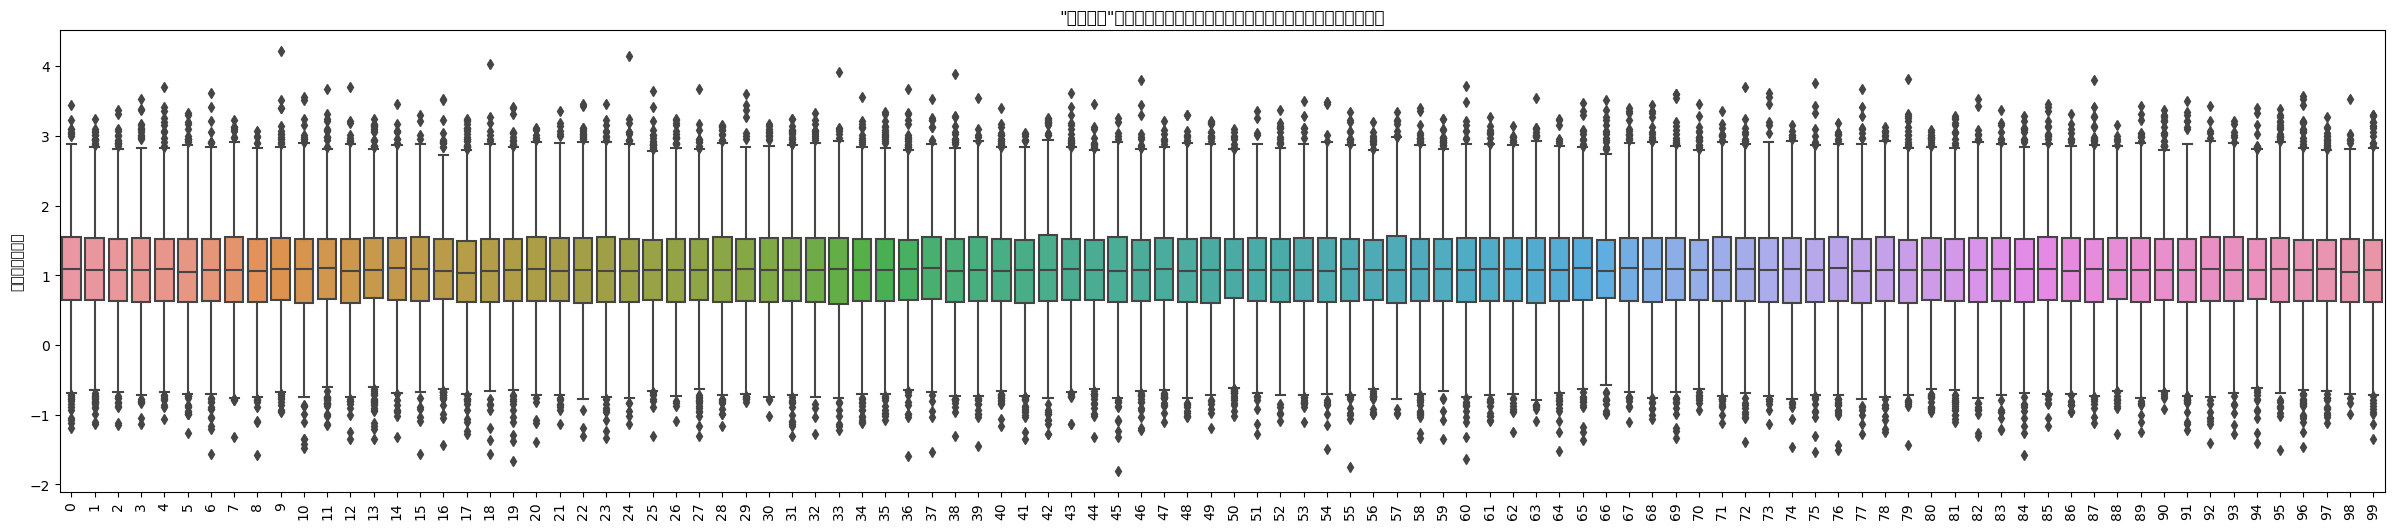

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

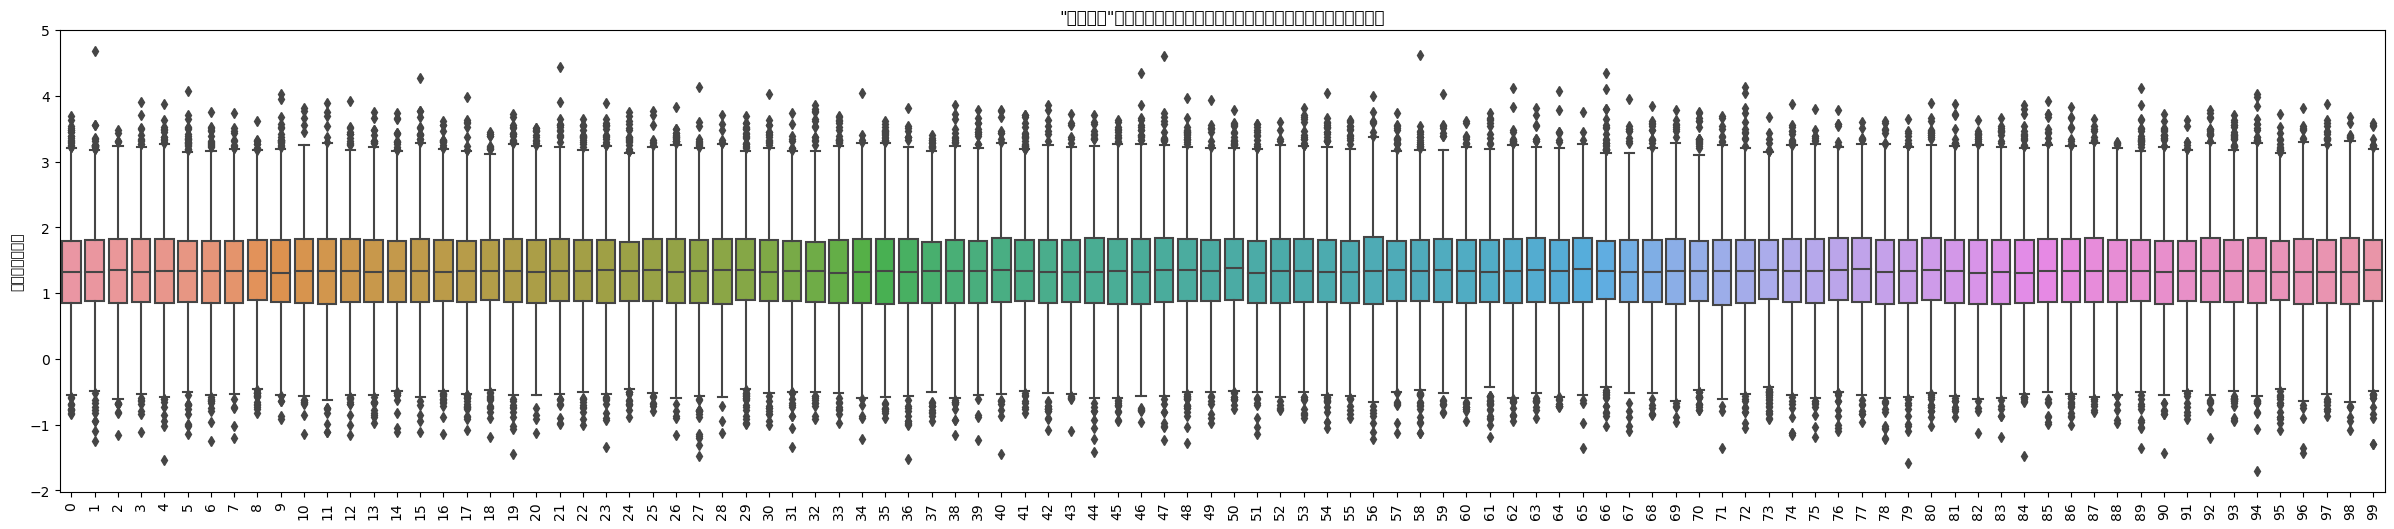

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

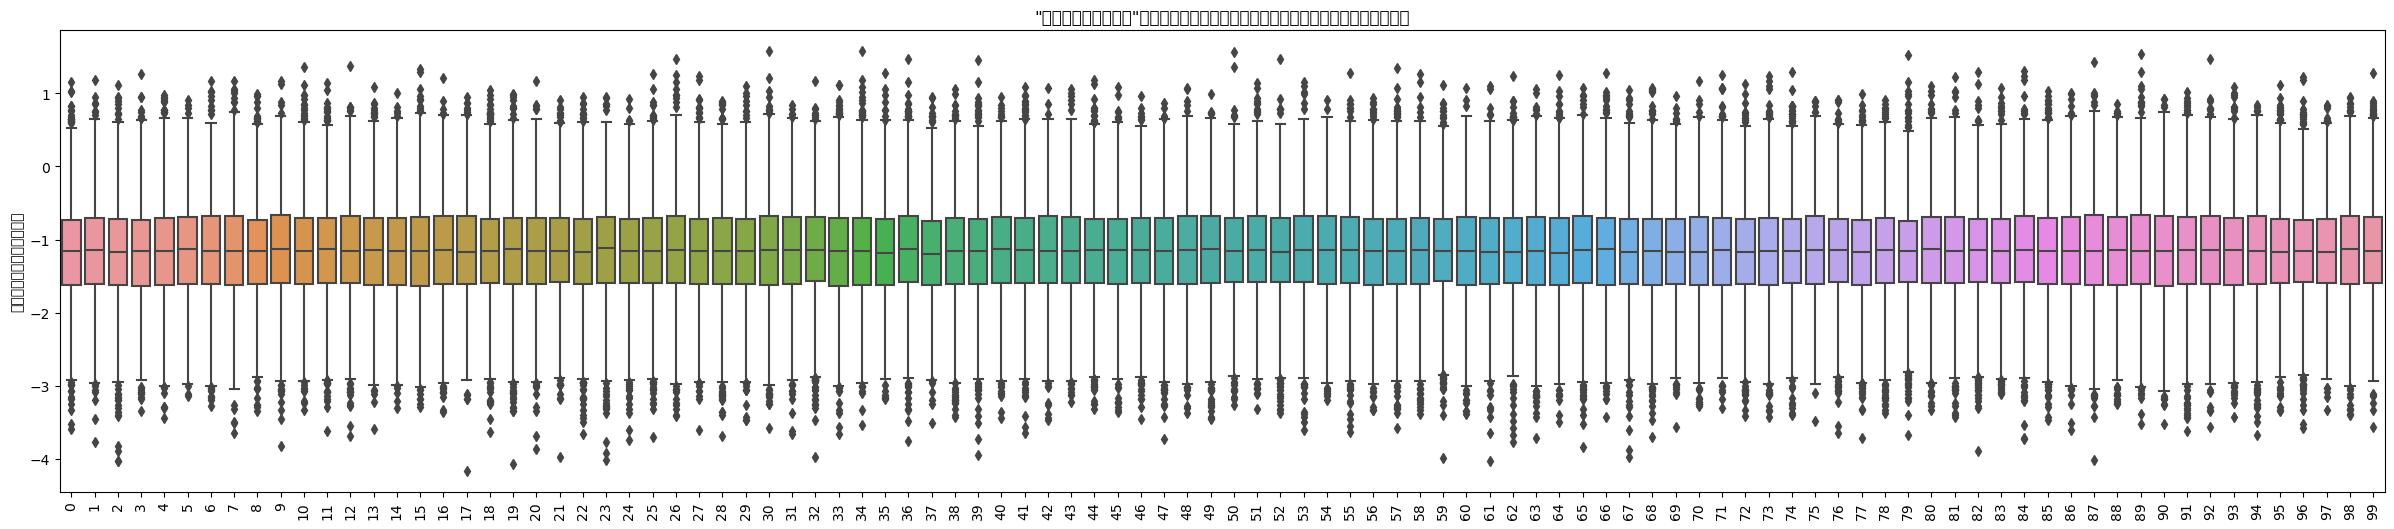

In [63]:
indivisual_count, indivisual_amount, indivisual_last_visit = random_coef_effect(trace, 'r_coef_')

indivisual_plot(indivisual_count, ylabel='購入回数の係数', title='"購入回数"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)
indivisual_plot(indivisual_amount, ylabel='購入金額の係数', title='"購入金額"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)
indivisual_plot(indivisual_last_visit, ylabel='最終来店からの日数の係数', title='"最終来店からの日数"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)


/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844

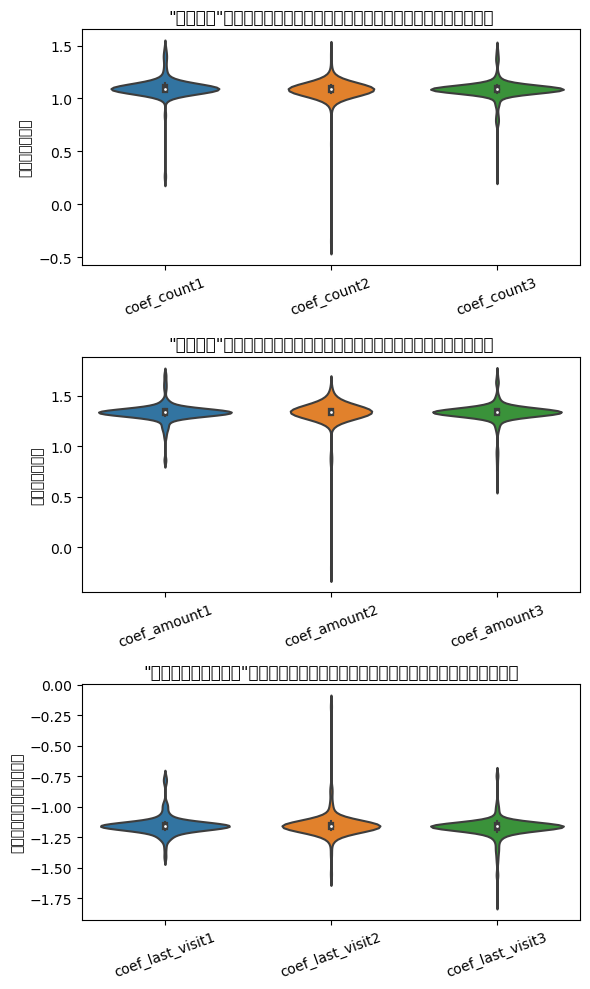

In [66]:
# 女性で学生ならcoef_****1, 男性でProfessionalならcoef_****2, 年齢が40以上で未婚ならcoef_****3
# 女性で学生なら購入回数の係数が大きく、
# 男性でProfessionalなら購入金額の係数が大きく、
# 年齢が40以上で未婚なら最終来店日からの日数の係数が負の方向に大きいはず
indivisual_summary_plot(train_df, democols, indivisual_count, indivisual_amount, indivisual_last_visit)


予測サンプル生成（テストデータ）

Sampling: [obs, r_coef_, r_intercept_]


accuracy_score 0.9237057220708447
precision_score 0.8305084745762712
recall_score 0.7313432835820896
f1_score 0.7777777777777778


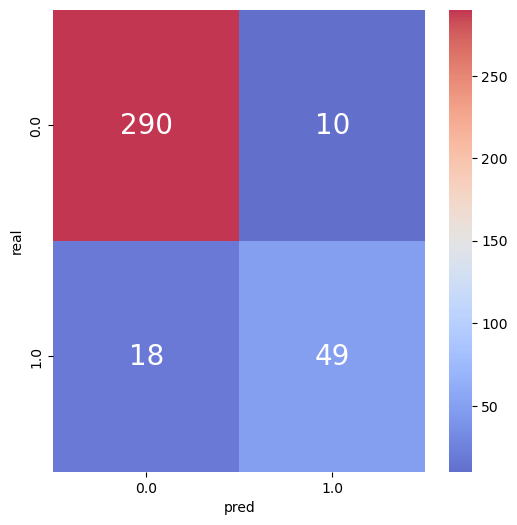

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


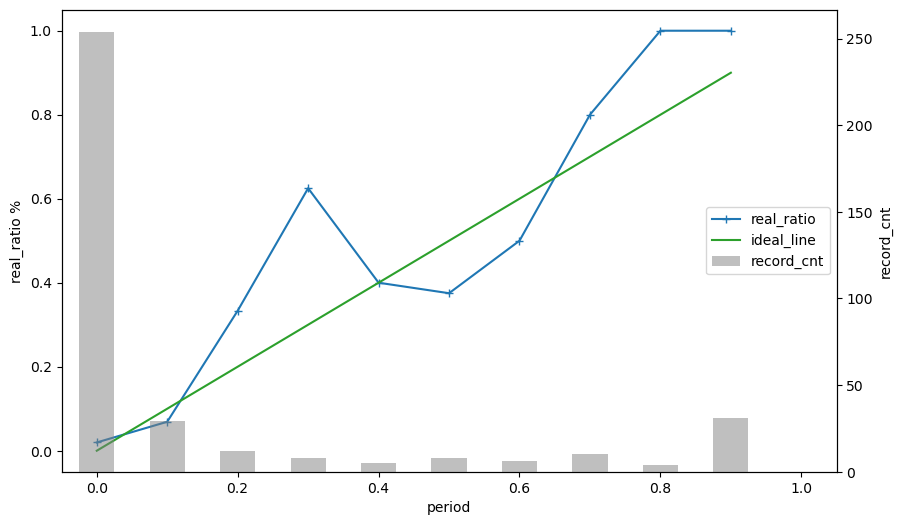

period  real_ratio  record_cnt
0     0.0    0.019685         254
1     0.1    0.068966          29
2     0.2    0.333333          12
3     0.3    0.625000           8
4     0.4    0.400000           5
5     0.5    0.375000           8
6     0.6    0.500000           6
7     0.7    0.800000          10
8     0.8    1.000000           4
9     0.9    1.000000          31

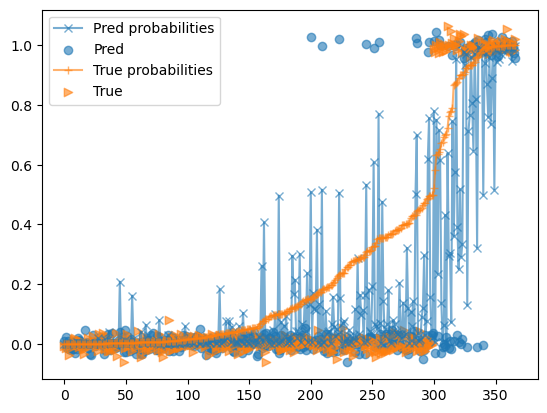

In [67]:
# テストデータの推論
with model_random1:
    pm.set_data({'x':test_df[purchasecols].to_numpy()
                 , 'y': np.zeros(len(test_df[purchasecols].to_numpy()))  # yは未知とする。実際の答えはtest_df['purchase'].to_numpy()。
                }
                , coords={"data": (np.arange(test_df.shape[0]))+train_df.shape[0]}
               )
    trace.extend(pm.sample_posterior_predictive(trace))

# テストデータを使って予測
p_preds_test = trace.posterior_predictive["obs"].mean(dim=["chain"]).values  # chain平均
p_pred_test = trace.posterior_predictive["obs"].mean(dim=["chain", "draw"]).values  # chainとサンプル平均
y_pred_test = (p_pred_test >= 0.5).astype("int")  # 0.5以上を1
y_true_test = test_df['purchase'].to_numpy()  # 実際の購買有無
p_true_test = test_df['probabilities'].to_numpy()
result_summary(p_true_test, p_pred_test, y_true_test, y_pred_test)


### 階層ベイズ２項ロジットモデル、属性情報あり、固定効果あり、ランダム効果あり

In [71]:
democols

['gender',
 'age',
 'marital_status',
 'occupation_Homemaker',
 'occupation_Other',
 'occupation_Professional']

In [69]:
# モデルの定義
with pm.Model() as model_random2:
    # coords
    model_random2.add_coord('data', values=range(train_df.shape[0]), mutable=True)
    model_random2.add_coord('var', values=purchasecols, mutable=True)
    model_random2.add_coord('demo_var', values=democols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', train_df[purchasecols].to_numpy(dtype='float32'), dims=('data', 'var'))
    y = pm.MutableData("y", train_df['purchase'].to_numpy(dtype='float32'), dims=('data', ))
    demo_x = pm.MutableData('demo_x', train_df[democols].to_numpy(dtype='float32'), dims=('data', 'demo_var'))

    # 超事前分布
    coef_demo_keisuu = pm.StudentT('coef_demo_keisuu', nu=4, mu=0, sigma=1.0, dims=('var', 'demo_var'))  # ランダム係数の平均の超事前分布
    intercept_demo_keisuu = pm.StudentT('intercept_demo_keisuu', nu=4, mu=0.0, sigma=1.0, dims=('data', 'var'))  # ランダム係数の平均の超事前分布
    #rsigma_keisuu = pm.HalfStudentT('rsigma_keisuu', nu=4, dims=('data', 'var'))  #  MCMC収束しなかったので設定しない
    coef_demo_seppen = pm.StudentT('coef_demo_seppen', nu=4, mu=0, sigma=1.0, dims=('demo_var', ))  # ランダム切片の平均の超事前分布
    intercept_demo_seppen = pm.StudentT('intercept_demo_seppen', nu=4, mu=0.0, sigma=1.0, dims=('data', ))  # ランダム切片の平均の超事前分布
    #rsigma_seppen = pm.HalfStudentT('rsigma_seppen', nu=4, dims=('data', ))#pm.HalfCauchy('rsigma', mu=0.0, sigma=1)  #  MCMC収束しなかったので設定しない
    
    # 推論パラメータの事前分布    
    coef_ = pm.StudentT('coef', nu=4, mu=0.0, sigma=1, dims=('var', ))  # 固定効果
    intercept_ = pm.StudentT('intercept', nu=4, mu=0.0, sigma=1)  # 固定効果
    r_keisuu = pm.StudentT('r_keisuu', nu=4, mu=coef_demo_keisuu.dot(demo_x.T).T + intercept_demo_keisuu, sigma=1, dims=('data', 'var'))  # ランダム効果 データ×係数の数分の値がある
    r_seppen = pm.StudentT('r_seppen', nu=4, mu=coef_demo_seppen.dot(demo_x.T).T + intercept_demo_seppen, sigma=1, dims=('data', ))  # ランダム効果 データの数分の値がある
    
    # linear model
    mu = pm.Deterministic("mu", pm.math.sum((coef_ + r_keisuu) * x, axis=1) + intercept_ + r_seppen, dims=('data', ))
    # link function
    link = pm.Deterministic("link", pm.math.invlogit(mu), dims=('data', ))
    # likelihood
    result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))


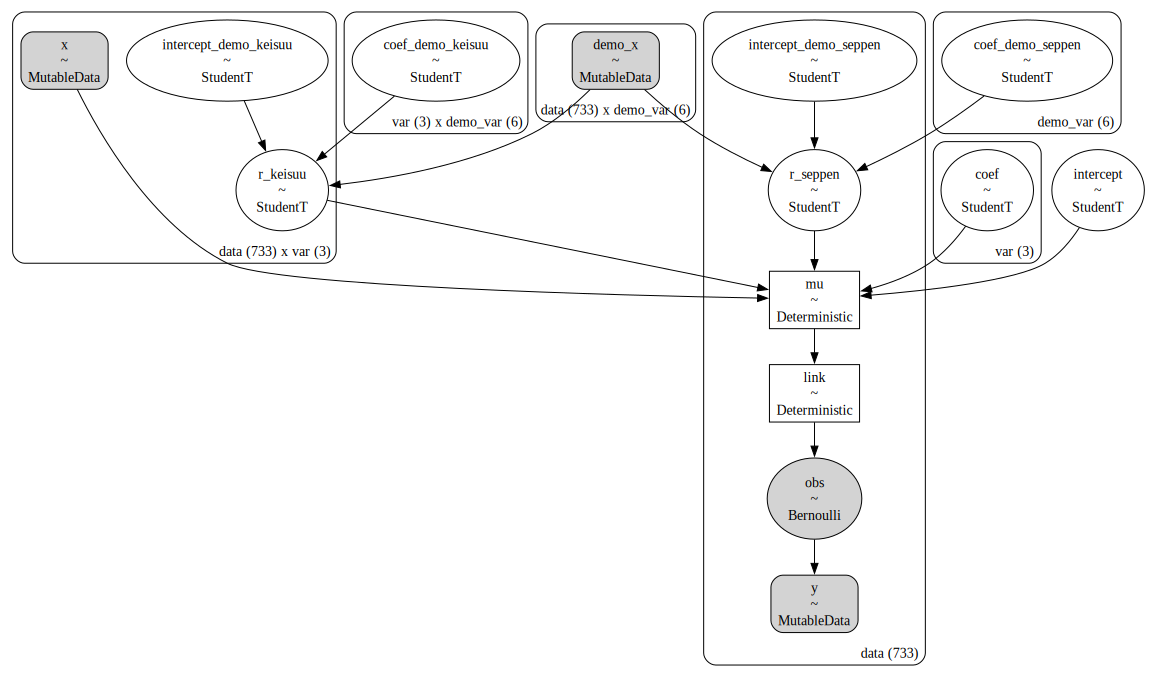

In [70]:
# 構造
modeldag = pm.model_to_graphviz(model_random2)
display(modeldag)


In [72]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_random2:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True)
# >> Wall time: 6min 42s

# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random2.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random2.nc')


Compiling...
Compilation time =  0:00:04.780056
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 0:   5%|▌         | 200/4000 [00:21<06:10, 10.26it/s]

Running chain 0:  10%|█         | 400/4000 [00:35<04:55, 12.19it/s]

Running chain 0:  15%|█▌        | 600/4000 [00:57<05:20, 10.62it/s]


Running chain 0:  20%|██        | 800/4000 [01:22<05:37,  9.47it/s]


Running chain 2: 100%|██████████| 4000/4000 [03:40<00:00, 18.11it/s]


Sampling time =  0:03:41.126576
Transforming variables...
Transformation time =  0:00:00.509119
CPU times: user 9min 52s, sys: 18.6 s, total: 10min 10s
Wall time: 4min 14s


'model_random2.nc'

In [73]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ["coef", "intercept", "r_coef_", "r_intercept_"]])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')

'''
# Energy Plot
az.plot_energy(trace)
plt.show()
'''


Max rhat: 1.0333428639178992


'\n# Energy Plot\naz.plot_energy(trace)\nplt.show()\n'

{'purchase_count': 3.52, 'purchase_amount': 5.3, 'last_visit': -0.69}


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


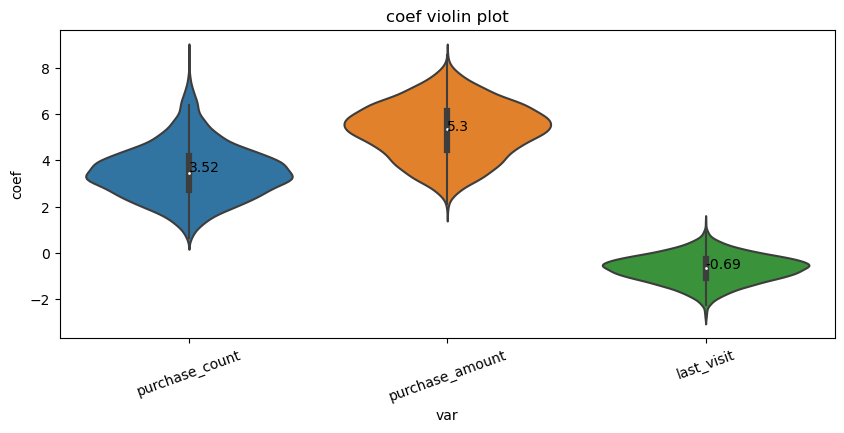

In [75]:
corf_df = pd.DataFrame(trace.posterior['coef'].mean(dim=["chain"]).values, columns=purchasecols)
coef_dict = {i:round(corf_df[i].mean(),2) for i in purchasecols}
print(coef_dict)
plot_violin(corf_df, order=None, xlabel='var', ylabel='coef', title='coef violin plot')


In [78]:
trace.posterior['coef'].shape

(3, 3000, 3)

In [79]:
trace.posterior['coef'].mean(dim=['chain']).shape

(3000, 3)

{'purchase_count': 3.38, 'purchase_amount': 5.39, 'last_visit': -0.79}


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


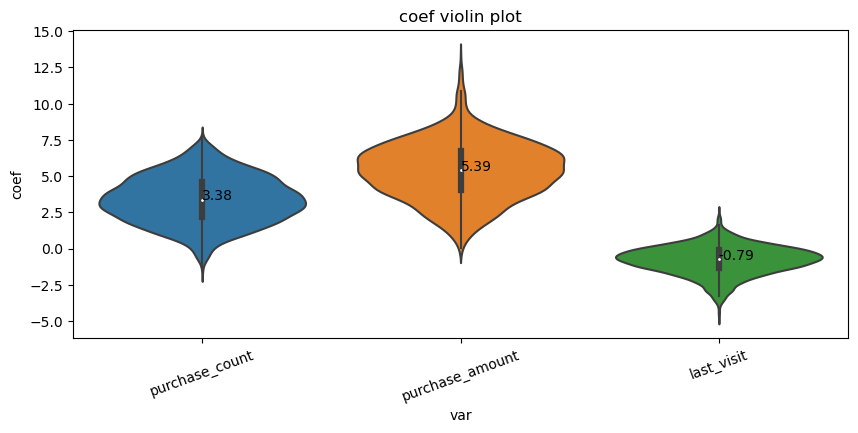

In [83]:
corf_df = pd.DataFrame(trace.posterior['coef'][0].values, columns=purchasecols)
coef_dict = {i:round(corf_df[i].mean(),2) for i in purchasecols}
print(coef_dict)
plot_violin(corf_df, order=None, xlabel='var', ylabel='coef', title='coef violin plot')

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

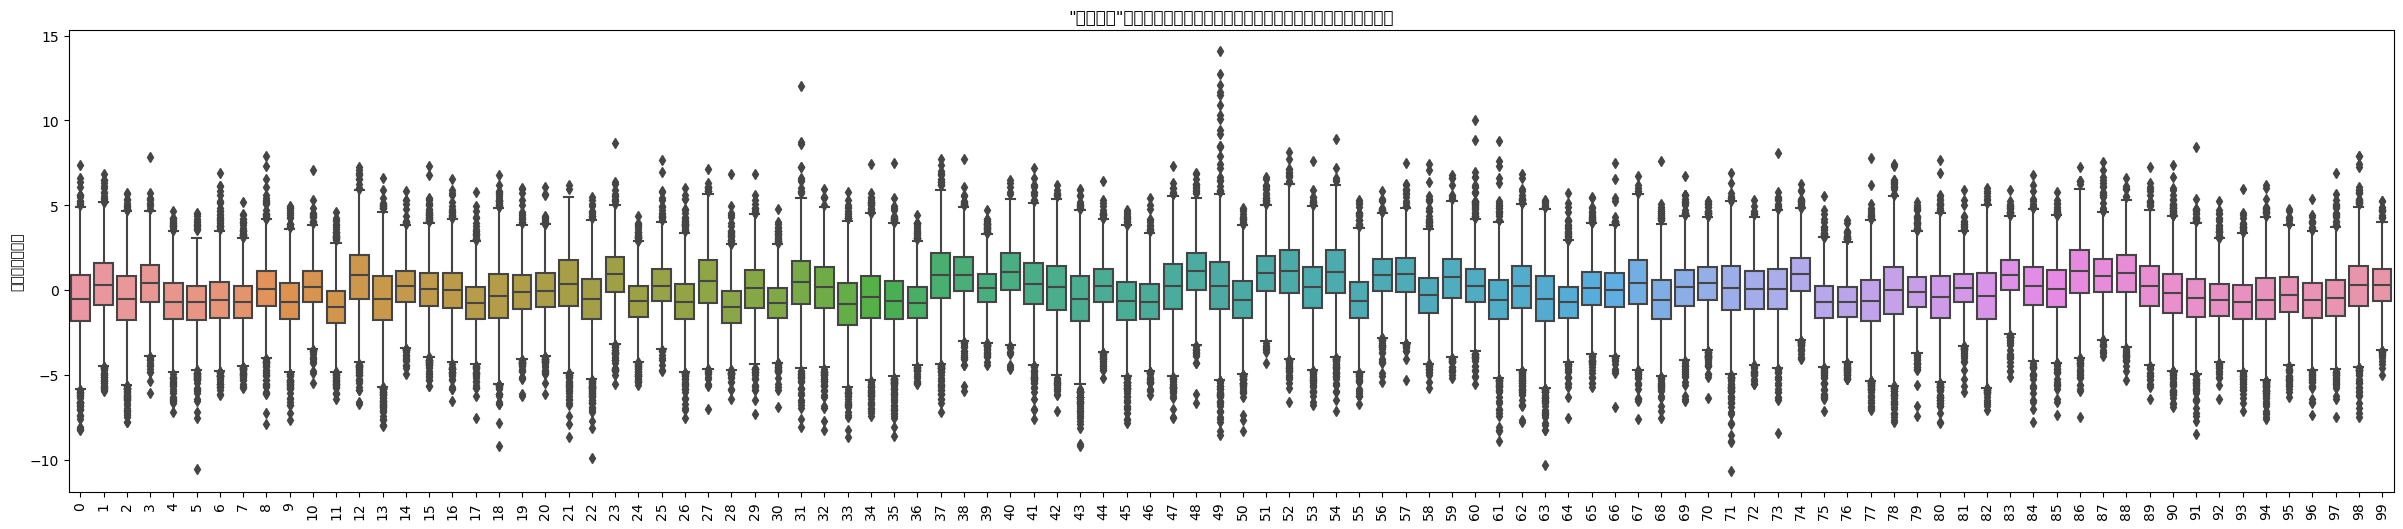

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

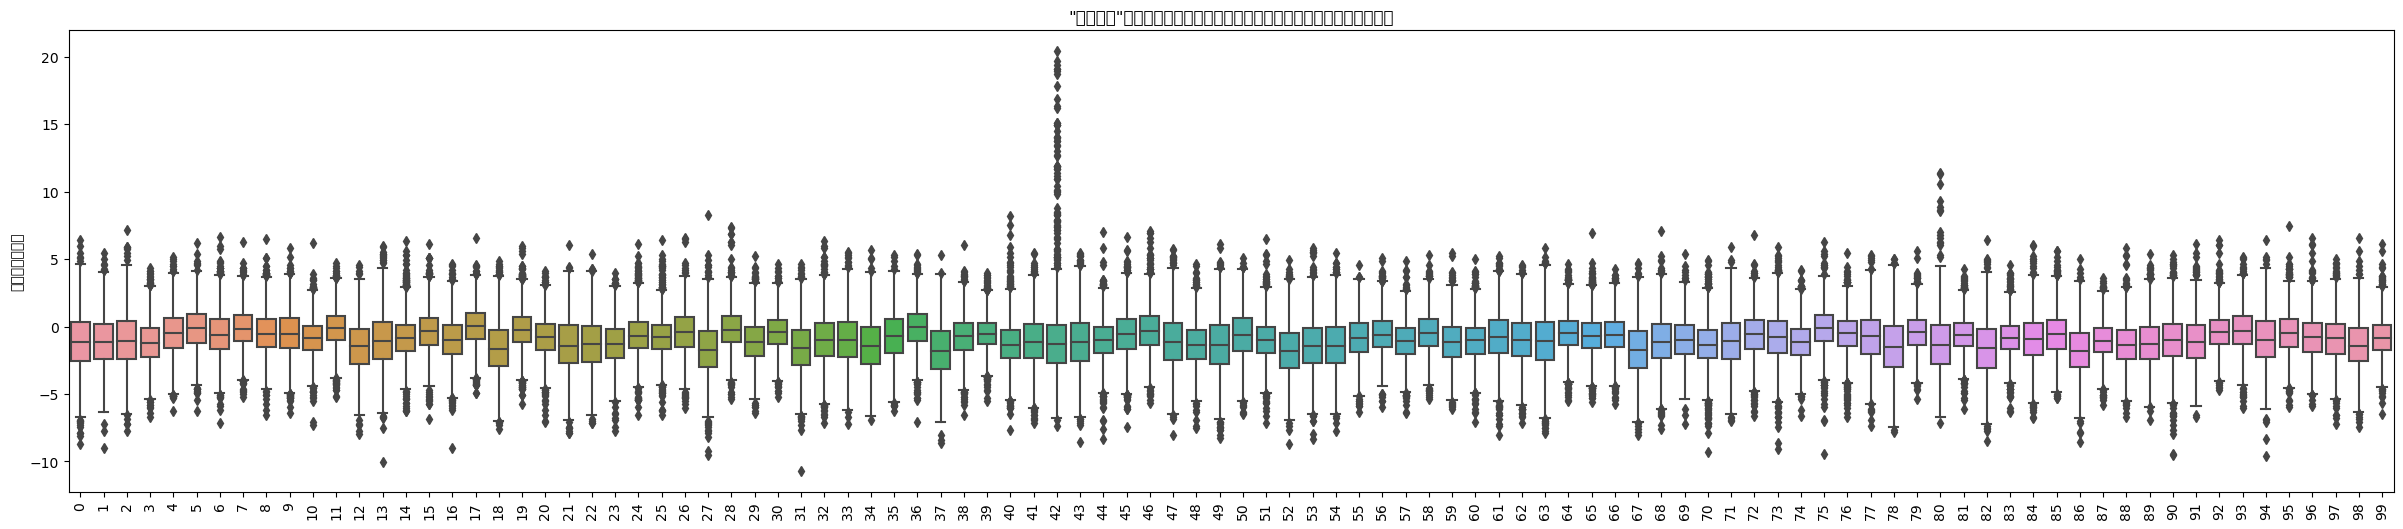

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

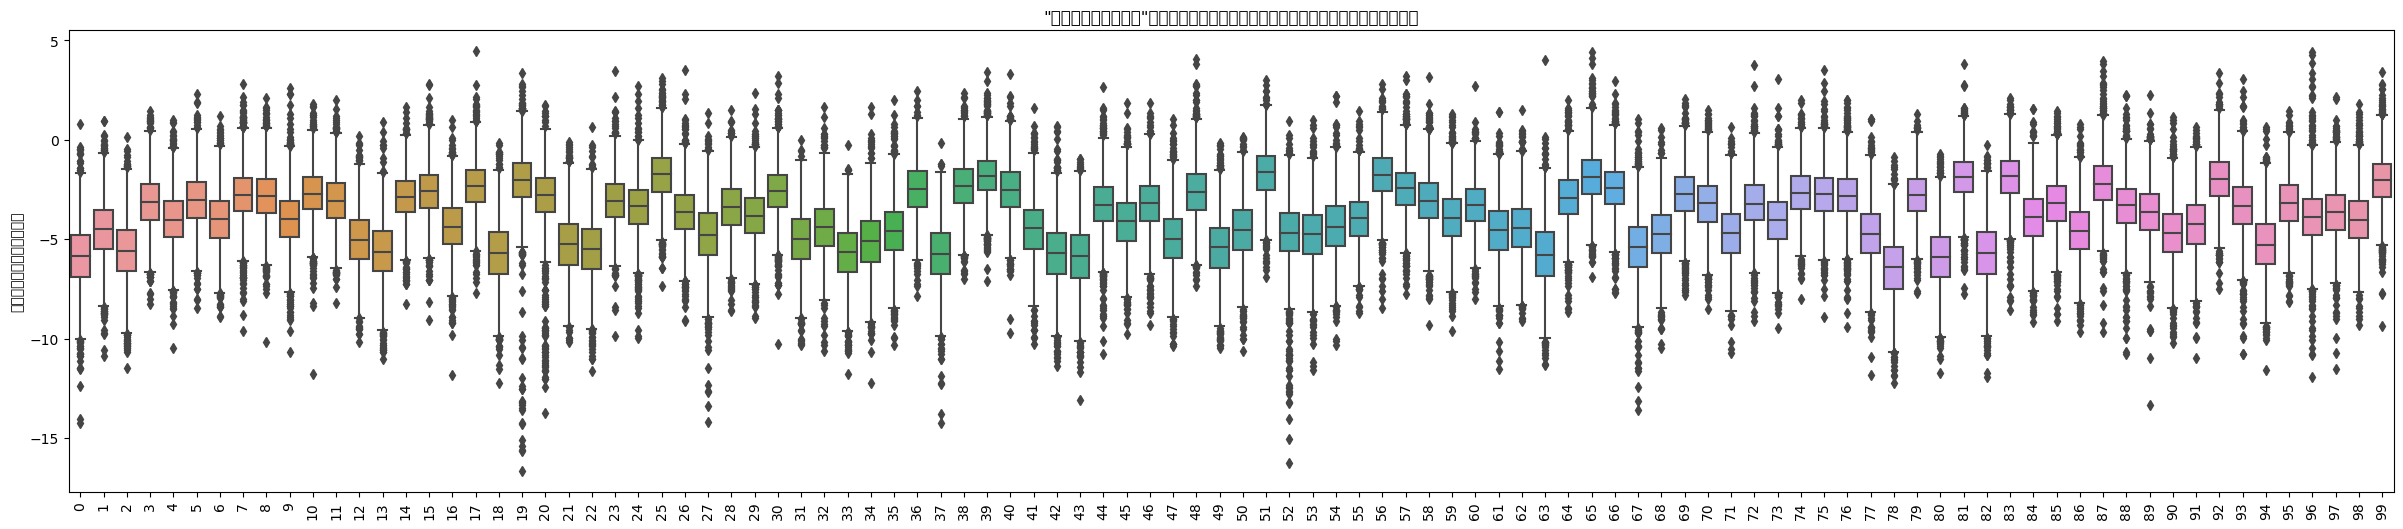

In [84]:
indivisual_count, indivisual_amount, indivisual_last_visit = random_coef_effect(trace, 'r_keisuu')

indivisual_plot(indivisual_count, ylabel='購入回数の係数', title='"購入回数"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)
indivisual_plot(indivisual_amount, ylabel='購入金額の係数', title='"購入金額"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)
indivisual_plot(indivisual_last_visit, ylabel='最終来店からの日数の係数', title='"最終来店からの日数"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)


/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844

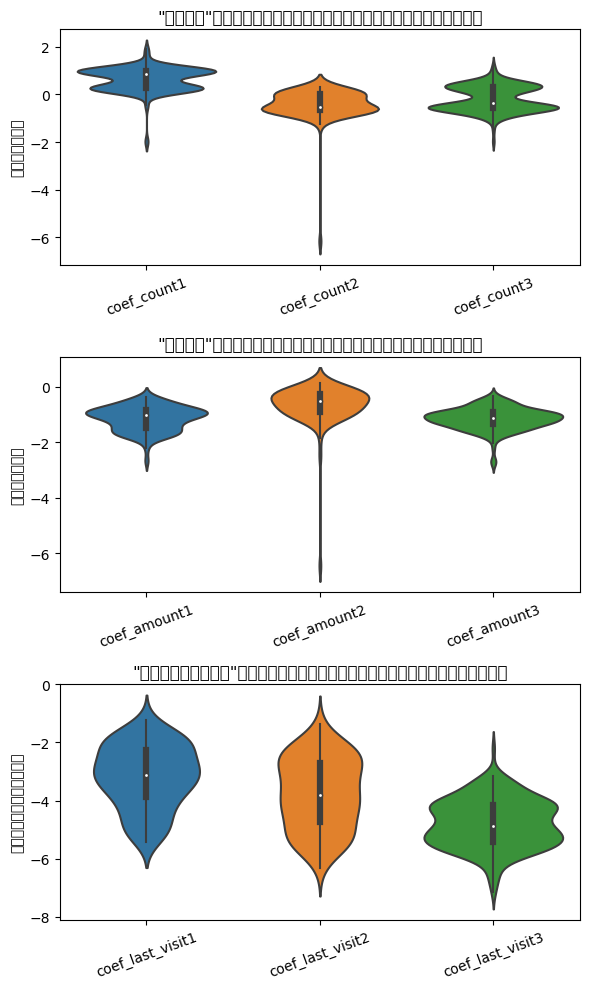

In [85]:
# 女性で学生ならcoef_****1, 男性でProfessionalならcoef_****2, 年齢が40以上で未婚ならcoef_****3
# 女性で学生なら購入回数の係数が大きく、
# 男性でProfessionalなら購入金額の係数が大きく、
# 年齢が40以上で未婚なら最終来店日からの日数の係数が負の方向に大きいはず
indivisual_summary_plot(train_df, democols, indivisual_count, indivisual_amount, indivisual_last_visit)


予想サンプル生成（テストデータ）

Sampling: [intercept_demo_keisuu, intercept_demo_seppen, obs, r_keisuu, r_seppen]


accuracy_score 0.9182561307901907
precision_score 0.8135593220338984
recall_score 0.7164179104477612
f1_score 0.761904761904762


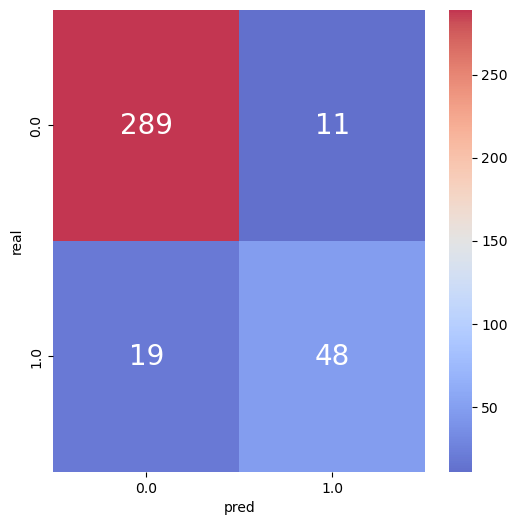

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


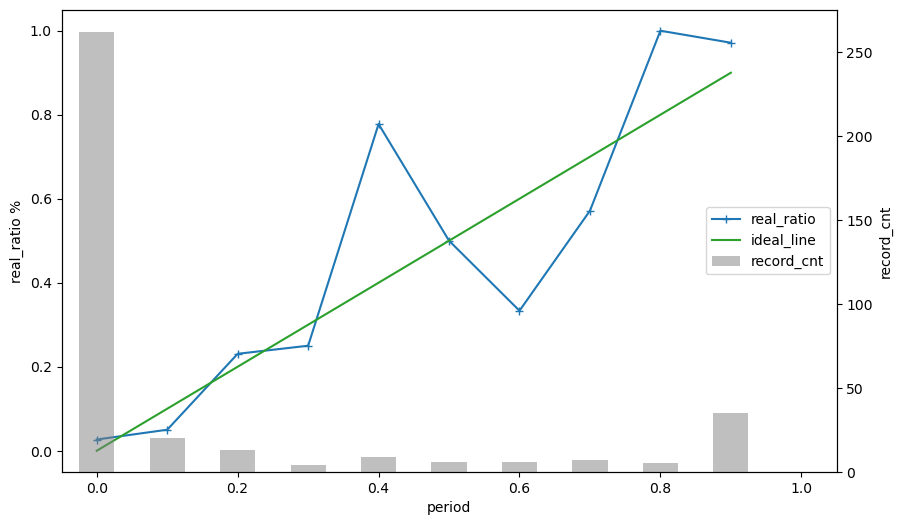

period  real_ratio  record_cnt
0     0.0    0.026718         262
1     0.1    0.050000          20
2     0.2    0.230769          13
3     0.3    0.250000           4
4     0.4    0.777778           9
5     0.5    0.500000           6
6     0.6    0.333333           6
7     0.7    0.571429           7
8     0.8    1.000000           5
9     0.9    0.971429          35

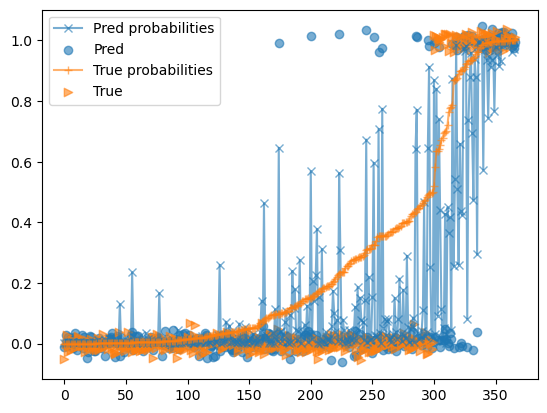

In [87]:
# テストデータの推論
with model_random2:
    pm.set_data({'demo_x':test_df[democols].to_numpy(dtype='float32')
                 , 'x':test_df[purchasecols].to_numpy(dtype='float32')
                 , 'y': np.zeros(len(test_df[purchasecols].to_numpy(dtype='float32')))  # yは未知とする。実際の答えはtest_df['purchase'].to_numpy()。
                }
                , coords={"data": (np.arange(test_df.shape[0]))+train_df.shape[0]}
               )
    trace.extend(pm.sample_posterior_predictive(trace))

# テストデータを使って予測
p_preds_test = trace.posterior_predictive["obs"].mean(dim=["chain"]).values  # chain平均
p_pred_test = trace.posterior_predictive["obs"].mean(dim=["chain", "draw"]).values  # chainとサンプル平均
y_pred_test = (p_pred_test >= 0.5).astype("int")  # 0.5以上を1
y_true_test = test_df['purchase'].to_numpy()  # 実際の購買有無
p_true_test = test_df['probabilities'].to_numpy()
result_summary(p_true_test, p_pred_test, y_true_test, y_pred_test)


### 階層ベイズ２項ロジットモデル、属性情報あり、固定効果なし、ランダム効果あり

In [89]:
# モデルの定義
with pm.Model() as model_random3:
    # coords
    model_random3.add_coord('data', values=range(train_df.shape[0]), mutable=True)
    model_random3.add_coord('demo_var', values=democols, mutable=True)
    model_random3.add_coord('purchase_var', values=purchasecols, mutable=True)

    # 変数
    demo_x = pm.MutableData('demo_x', train_df[democols].to_numpy(dtype='float32'), dims=('data', 'demo_var'))
    purchase_x = pm.MutableData('purchase_x', train_df[purchasecols].to_numpy(dtype='float32'), dims=('data', 'purchase_var'))
    y = pm.MutableData("y", train_df['purchase'].to_numpy(dtype='float32'), dims=('data', ))

    # 属性情報の推論パラメータの事前分布(超事前分布)
    coef_demo = pm.StudentT('coef_demo', mu=0, sigma=1, nu=4, dims=('purchase_var', "demo_var")) # pm.StudentT('coef_demo', mu=0, sigma=1, nu=4, dims=('purchase_var', "demo_var"))# pm.Normal('coef_demo', mu=0, sigma=1, dims=('purchase_var', "demo_var"))
    intercept_demo = pm.StudentT('intercept_demo', mu=0, sigma=1, nu=4, dims=('purchase_var', )) # pm.StudentT('intercept_demo', mu=0, sigma=1, nu=4, dims=('purchase_var', ))# pm.Normal('intercept_demo', mu=0, sigma=1, dims=('purchase_var', ))
    coef_demo_intercept = pm.StudentT('coef_demo_intercept', mu=0, sigma=1, nu=4, dims=("demo_var", )) # pm.StudentT('coef_demo_intercept', mu=0, sigma=1, nu=4, dims=("demo_var", ))# pm.Normal('coef_demo_intercept', mu=0, sigma=1, dims=("demo_var", ))
    intercept_demo_intercept = pm.StudentT('intercept_demo_intercept', mu=0, sigma=1, nu=4) # pm.StudentT('intercept_demo_intercept', mu=0, sigma=1, nu=4, dims=('data', ))# pm.Normal('intercept_demo_intercept', mu=0, sigma=1, dims=('data', ))

    #sigma_coef_purchase = pm.HalfStudentT('sigma_coef_purchase', nu=4)
    #sigma_intercept_purchase = pm.HalfStudentT('sigma_intercept_purchase', nu=4)
    
    # 説明変数の推論パラメータの事前分布
    #ccoef_purchase = pm.Deterministic("coef_purchase", coef_demo.dot(demo_x.T).T + intercept_demo, dims=("data", 'purchase_var'))  # データ分の値がある
    coef_purchase = pm.StudentT('coef_purchase', nu=4, mu=coef_demo.dot(demo_x.T).T + intercept_demo, sigma=1, dims=("data", 'purchase_var'))
    intercept_purchase = pm.StudentT('intercept_purchase', nu=4, mu=coef_demo_intercept.dot(demo_x.T).T + intercept_demo_intercept, sigma=1, dims=('data', ))

    # linear model
    #mu = pm.Normal("mu", mu=pm.math.sum(coef_purchase*purchase_x, axis=1) + intercept_purchase, sigma=1.0, dims=('data', ))  # データ分の値がある
    mu = pm.Deterministic("mu", pm.math.sum(coef_purchase*purchase_x, axis=1) + intercept_purchase, dims=('data', ))  # データ分の値がある
    # link function
    link = pm.Deterministic("link", pm.math.invlogit(mu), dims=('data', ))
    # likelihood
    results = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))


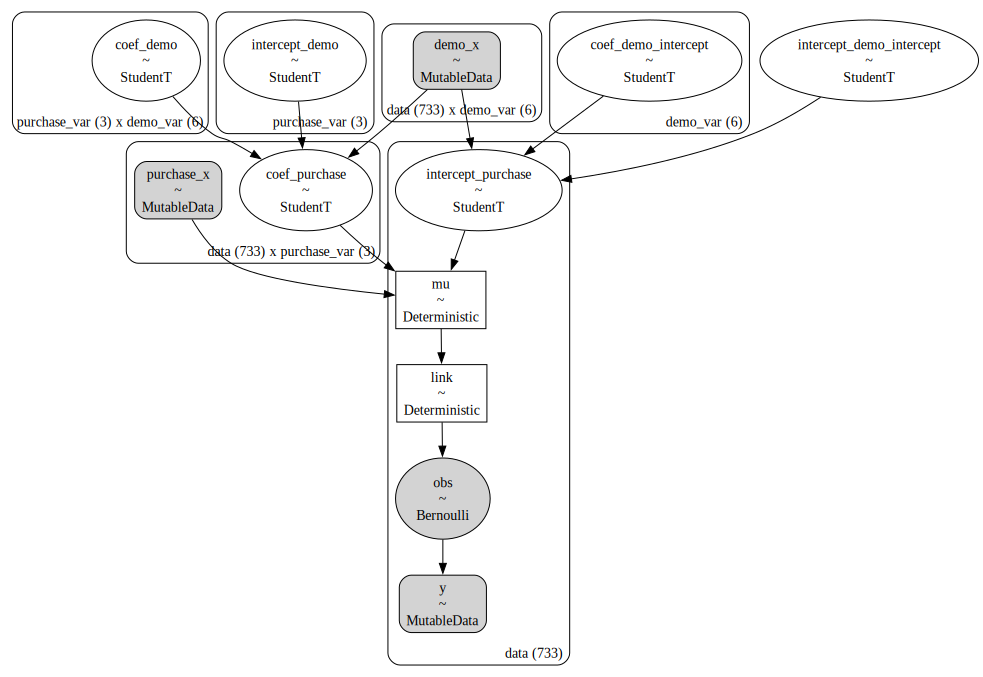

In [90]:
# 構造
modeldag = pm.model_to_graphviz(model_random3)
display(modeldag)


In [91]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_random3:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True)
# >> Wall time: 3min 23s

# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random3.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random3.nc')


Compiling...
Compilation time =  0:00:02.979561
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]

Running chain 0:  10%|█         | 400/4000 [00:19<02:31, 23.73it/s]

Running chain 0:  25%|██▌       | 1000/4000 [00:33<01:19, 37.61it/s]

Running chain 0:  30%|███       | 1200/4000 [00:47<01:53, 24.70it/s]


Running chain 0:  35%|███▌      | 1400/4000 [01:01<02:10, 19.99it/s]


Running chain 0:  40%|████      | 1600/4000 [01:15<02:15, 17.72it/s]

Running chain 0:  45%|████▌     | 1800/4000 [01:28<02:12, 16.60it/s]


Running chain 2: 100%|██████████| 4000/4000 [03:54<00:00, 17.02it/s]


Sampling time =  0:03:55.410920
Transforming variables...
Transformation time =  0:00:00.126668
CPU times: user 7min 23s, sys: 9.72 s, total: 7min 33s
Wall time: 4min 10s


'model_random3.nc'

In [92]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ["coef_purchase", "intercept_purchase", "r_coef_", "r_intercept_"]])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')

'''
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef_purchase", "intercept_purchase"])
plt.show()

# forest plotでRハットと一緒に可視化
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef_purchase"])
plt.tight_layout()
plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=["coef_purchase"], ref_val=0, figsize=(20,30))
plt.tight_layout()
plt.show()

# Energy Plot
az.plot_energy(trace)
plt.show()
'''


Max rhat: 1.0136360031685603


'\n# plot_trace\naz.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef_purchase", "intercept_purchase"])\nplt.show()\n\n# forest plotでRハットと一緒に可視化\naz.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef_purchase"])\nplt.tight_layout()\nplt.show()\n\n# 事後分布の確認\naz.plot_posterior(trace, hdi_prob=0.95, var_names=["coef_purchase"], ref_val=0, figsize=(20,30))\nplt.tight_layout()\nplt.show()\n\n# Energy Plot\naz.plot_energy(trace)\nplt.show()\n'

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

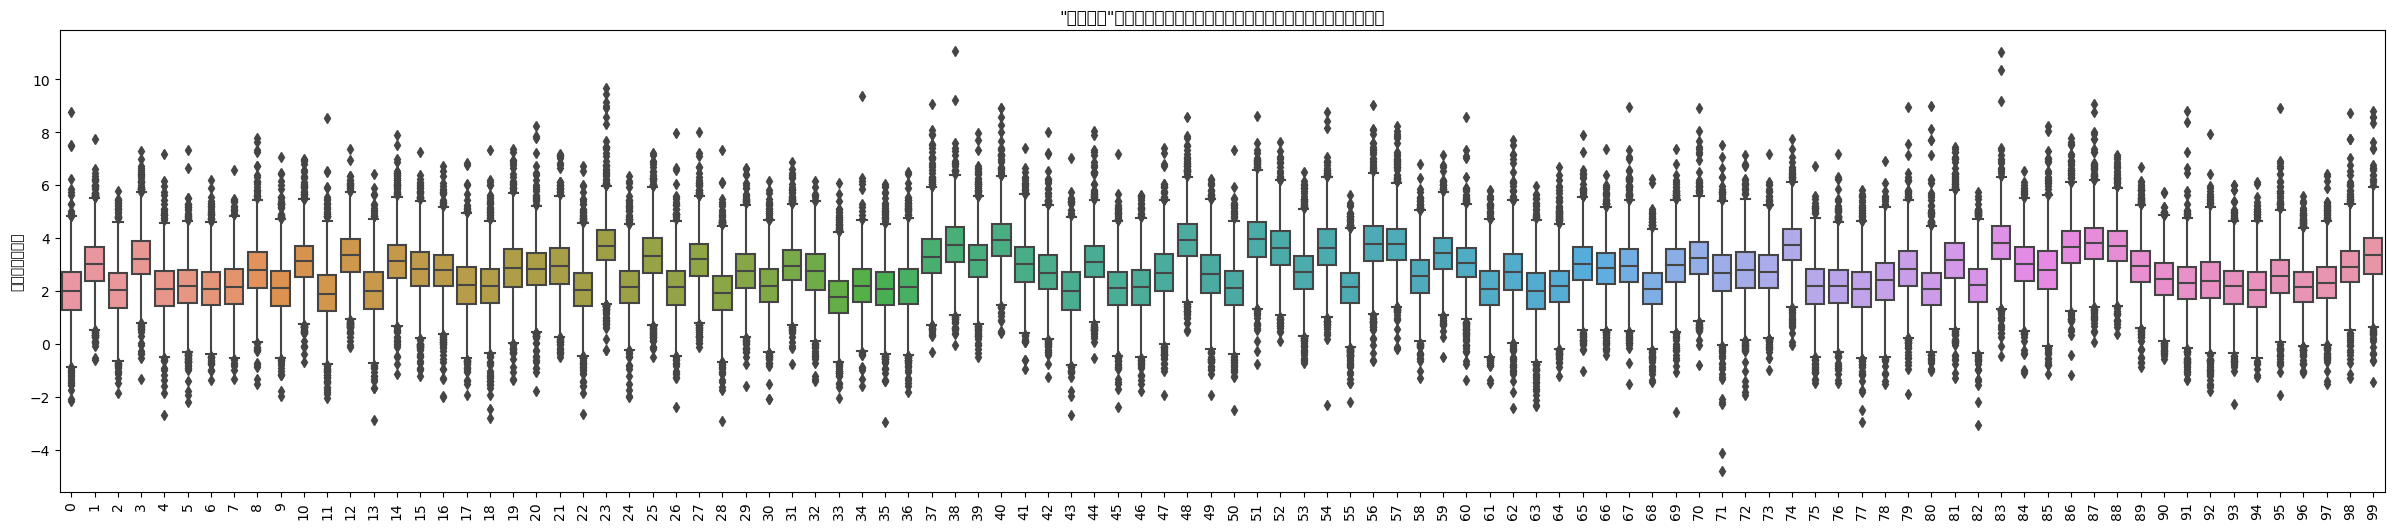

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

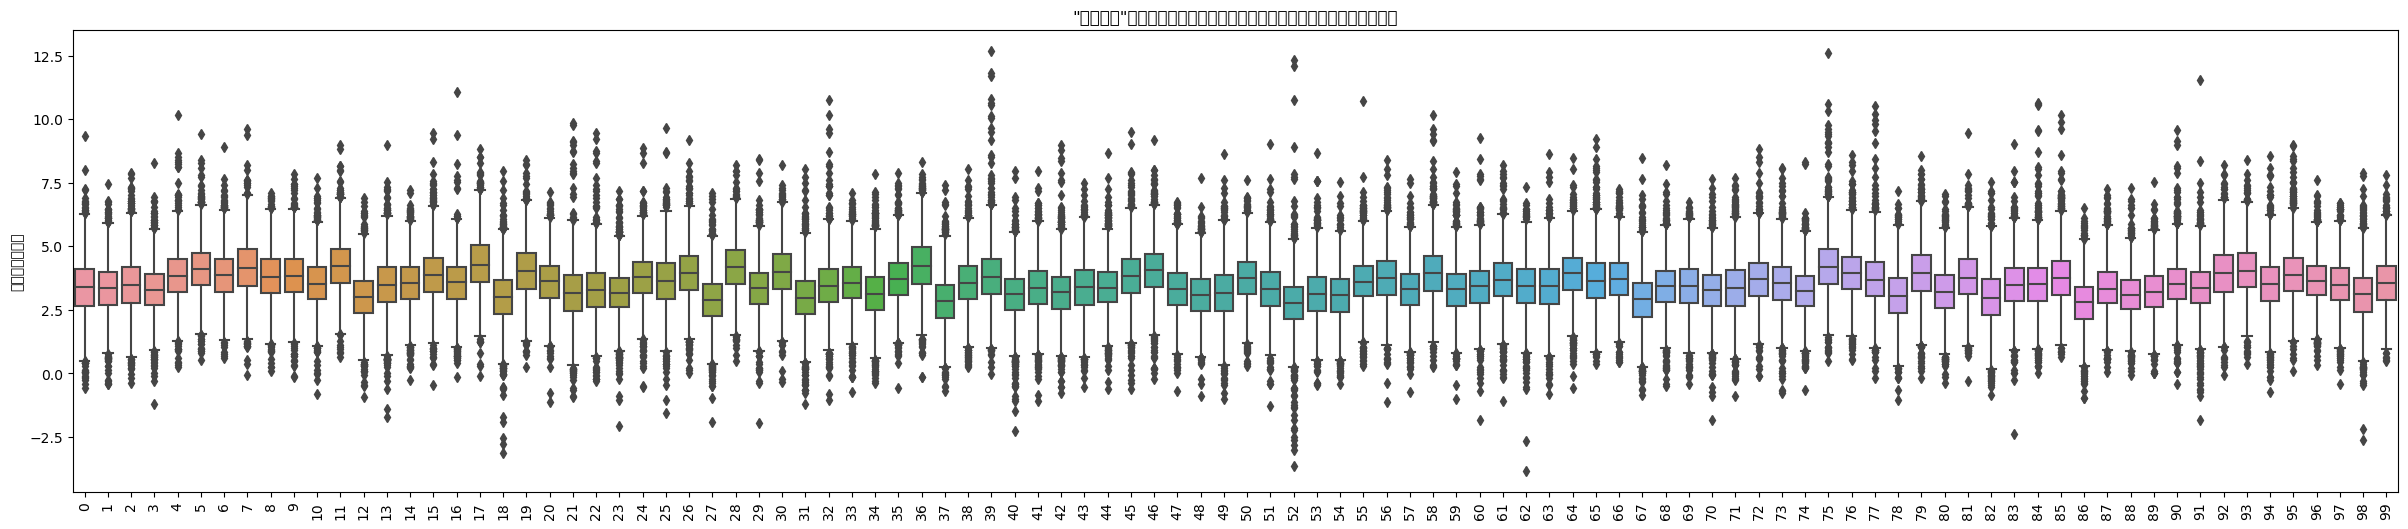

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

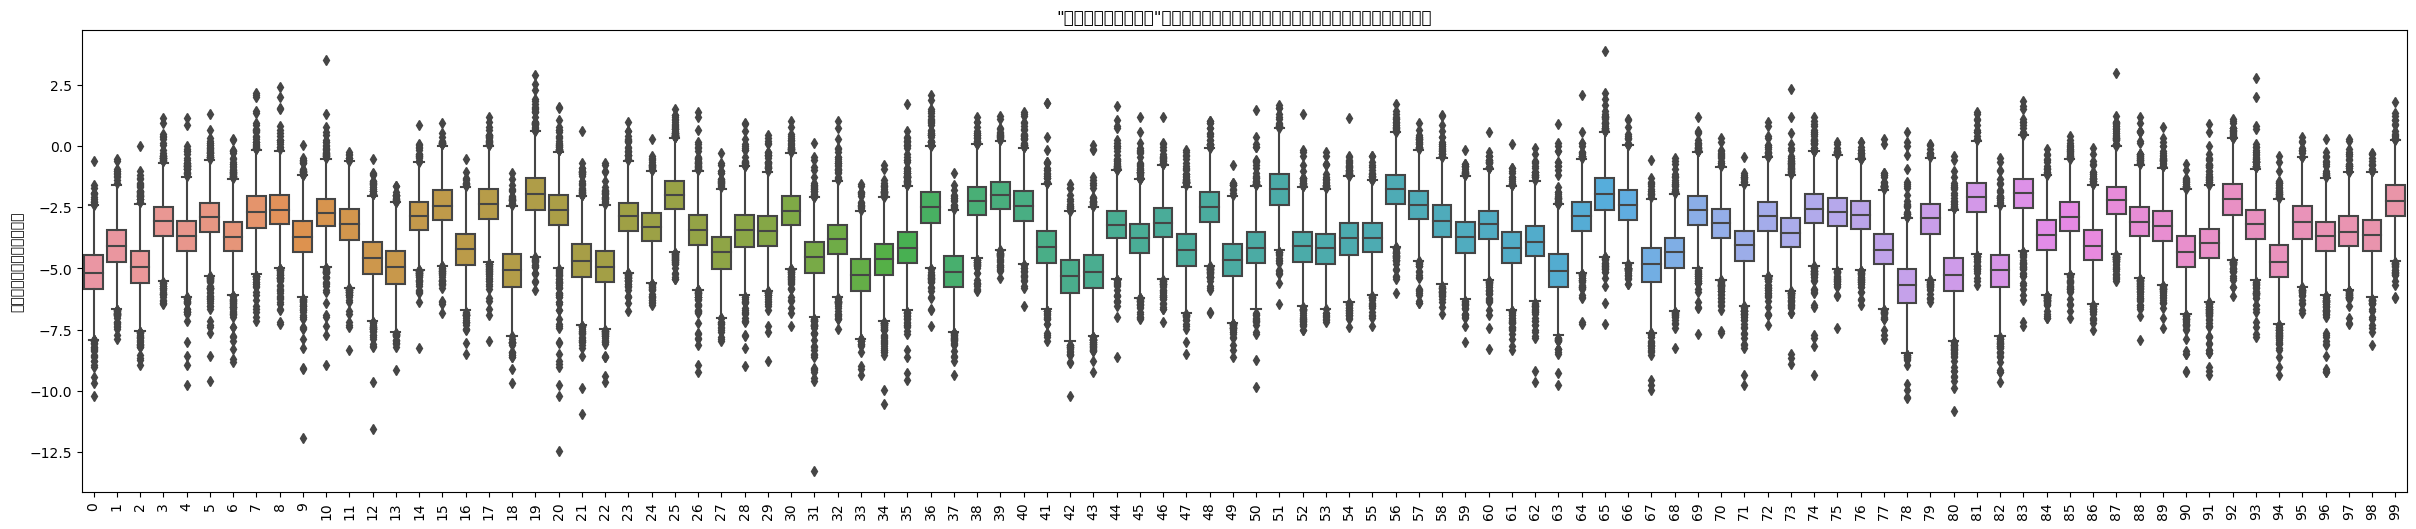

In [93]:
indivisual_count, indivisual_amount, indivisual_last_visit = random_coef_effect(trace, 'coef_purchase')

indivisual_plot(indivisual_count, ylabel='購入回数の係数', title='"購入回数"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)
indivisual_plot(indivisual_amount, ylabel='購入金額の係数', title='"購入金額"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)
indivisual_plot(indivisual_last_visit, ylabel='最終来店からの日数の係数', title='"最終来店からの日数"の係数が各個人の属性情報によってばらつくことをモデル化', brk=True)


/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:153: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844

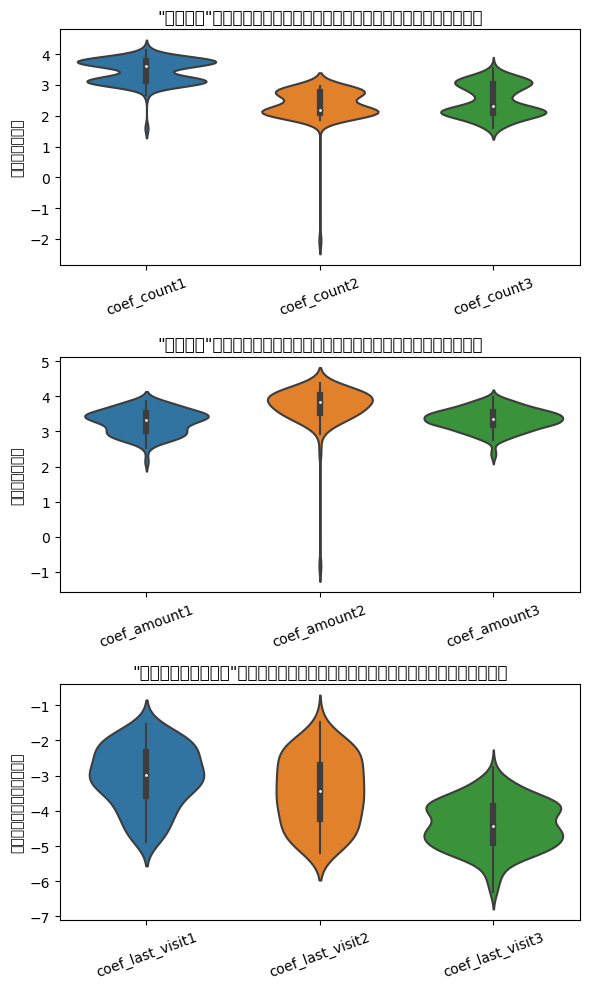

In [94]:
# 女性で学生ならcoef_****1, 男性でProfessionalならcoef_****2, 年齢が40以上で未婚ならcoef_****3
# 女性で学生なら購入回数の係数が大きく、
# 男性でProfessionalなら購入金額の係数が大きく、
# 年齢が40以上で未婚なら最終来店日からの日数の係数が負の方向に大きいはず
indivisual_summary_plot(train_df, democols, indivisual_count, indivisual_amount, indivisual_last_visit)


予測サンプル生成（テストデータ）

Sampling: [coef_purchase, intercept_purchase, obs]


accuracy_score 0.9182561307901907
precision_score 0.8135593220338984
recall_score 0.7164179104477612
f1_score 0.761904761904762


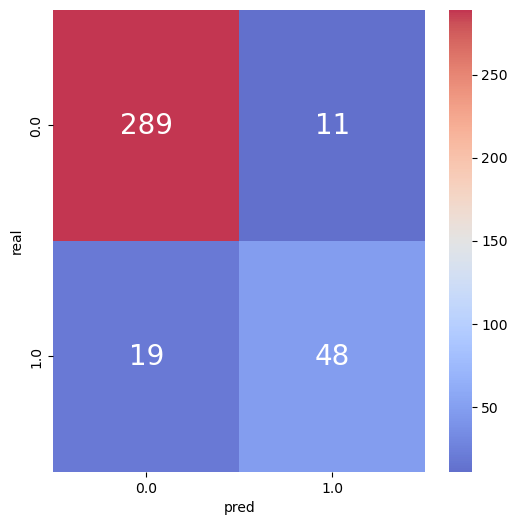

/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proba_check = pd.merge(proba_check.groupby(['period'])[['real']].mean().reset_index().rename(columns={'real':'real_ratio'})\
/var/folders/mb/p6b6l_1j25q0m7n939wwqwk00000gn/T/ipykernel_8844/3669774637.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  , proba_check.groupby(['period'])[['real']].count().reset_index().rename(columns={'real':'record_cnt'})\


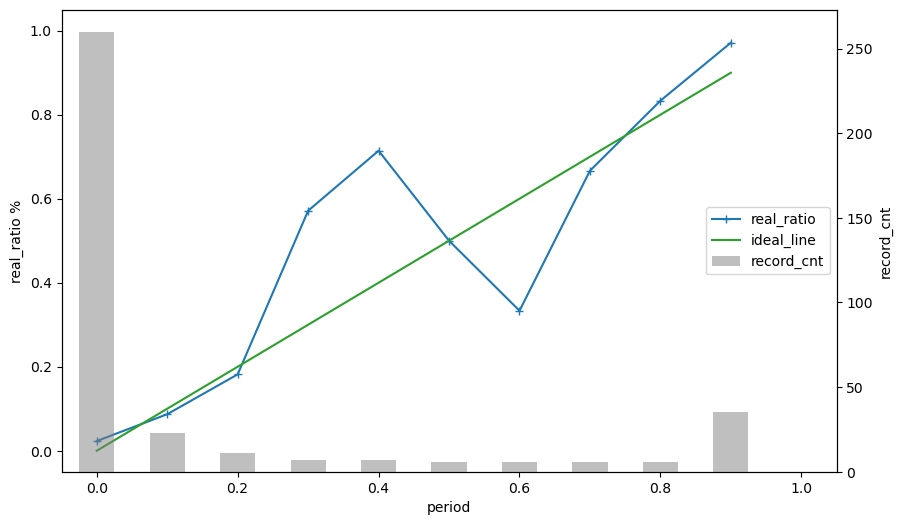

period  real_ratio  record_cnt
0     0.0    0.023077         260
1     0.1    0.086957          23
2     0.2    0.181818          11
3     0.3    0.571429           7
4     0.4    0.714286           7
5     0.5    0.500000           6
6     0.6    0.333333           6
7     0.7    0.666667           6
8     0.8    0.833333           6
9     0.9    0.971429          35

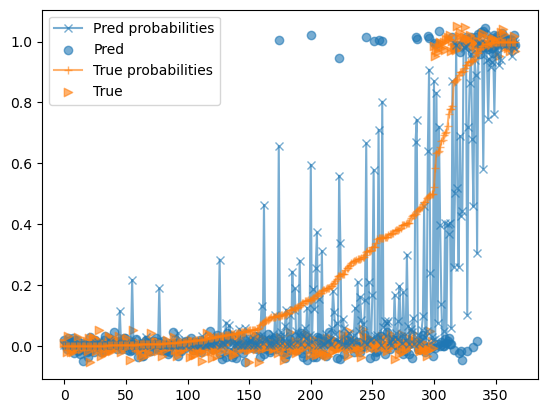

In [96]:
# テストデータの推論
with model_random3:
    pm.set_data({'demo_x':test_df[democols].to_numpy(dtype='float32')
                 , 'purchase_x':test_df[purchasecols].to_numpy(dtype='float32')
                 , 'y': np.zeros(len(test_df[purchasecols].to_numpy(dtype='float32')))  # yは未知とする。実際の答えはtest_df['purchase'].to_numpy()。
                }
                , coords={"data": (np.arange(test_df.shape[0]))+train_df.shape[0]}
               )
    trace.extend(pm.sample_posterior_predictive(trace))

# テストデータを使って予測
p_preds_test = trace.posterior_predictive["obs"].mean(dim=["chain"]).values  # chain平均
p_pred_test = trace.posterior_predictive["obs"].mean(dim=["chain", "draw"]).values  # chainとサンプル平均
y_pred_test = (p_pred_test >= 0.5).astype("int")  # 0.5以上を1
y_true_test = test_df['purchase'].to_numpy()  # 実際の購買有無
p_true_test = test_df['probabilities'].to_numpy()
result_summary(p_true_test, p_pred_test, y_true_test, y_pred_test)
